[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/prokaj/elte-python-2023/blob/main/2023-12-04.ipynb)   

Néhány import amit később használni fogunk:

In [1]:
import importlib
import math
import graphviz
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.auto import tqdm
import itertools

from IPython.display import SVG, Image, display_html

if importlib.util.find_spec('pycosat') is None:
    ! pip install --quiet pycosat

if importlib.util.find_spec('ipytest') is None:
    ! pip install --quiet ipytest

import ipytest

ipytest.autoconfig()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.0 MB/s eta 0:00:00


# Házi feladat

##### Polygon osztály további metódusai.

A gyakorlaton látott Polygon osztályt egészítsük ki egy is_inner metódussal, ami egy tetszőleges síkbeli pontról eldönti, hogy a polygon belsejében van-e (a visszatérési érték bool típusú, True vagy False).

Egy egyszerű algoritmus ennek eldöntésére a következő. Indítsunk ki egy félegyenest az adott pontból. Számoljuk meg, hogy hányszor metszi a polygont. Mivel a félegyenes ,,vége” a polygon külsejéhez tartozik és minden átmetszéssel egyik oldalról átkerülünk a másik oldalra ezért a metszések számának paritása megadja, hogy melyik oldalon vagyunk. Amire oda kell figyelni az az, hogy ha félegyenes tartalmazza valamelyik élet, akkor a fenti érvelés nem korrekt!

Egy másik lehetőség, a körülfordulási szám számolása. Itt az ötlet az, hogy minden élre számoljuk ki, mekkora szög alatt látszik és ezeket a szögeket előjelesen adjuk össze. Az eredmény a teljes szög többszöröse, a hányados a körülfordulási szám. Ha a töröttvonal nem kerüli meg a pontot akkor a külsőben vagyunk, ha egyszer kerüli meg, akkor a belsőben. Ha a töröttvonal polygon, akkor más lehetőség nincs.

Emellett implementáljuk az is_polygon metódust, ami ellenőrzi, hogy a polygon csúcsai között nincsennek ismétlődések és a különböző élek nem metszik egymást belső pontban. Az __init__ metódus egészítsük ki ellenőrzéssel, ha a kapott csúcs sorozatot nem tekinthető polygonnak dobjon hibát!

Ellenőrzésképpen készítsünk néhány polygont, legyen köztük konvex és nem konvex is és rajzoljuk a Polygon típus draw metódusával. Az ábra tartalmazzon egy választott pontot a belőle kiinduló félegyenes alkalmas darabjával és a metszéspontokkal.


In [2]:
import math
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt


In [3]:

class Point(np.ndarray):
    def __new__(cls, point):
        point = np.asarray(point)
        assert point.shape[-1] == 2
        return point.view(cls)

    def __repr__(self):
        if self.ndim > 1:
            return "Array of Points"
        else:
            a, b =  self
        return f"Point{(a,b)}"

Vec = Point

In [4]:
class Line:
    def __init__(self, P1, P2):
        self.P1, self.P2 = Point(P1), Point(P2)

    def p_v(self):
        return self.P1, self.P2-self.P1

    def is_parallel(self, other) -> bool:
        v0 = self.P2-self.P1
        v1 = other.P2-other.P1
        return np.linalg.det(np.stack((v0, v1))) == 0

    def intersection(self, other):
        p0, v0 = self.p_v()
        p1, v1 = other.p_v()
        if (rotate90(v0)*v1).sum() != 0:
            A = np.stack((v0, v1), axis=-1)
            x = p1-p0
            t, s = np.linalg.solve(A, x)
            return t
        else:
            return np.inf

    def side(self, points):
        p0, v0 = self.p_v()
        n = rotate90(v0)
        side = (np.array(points)-p0) @ n
        if (side>=0).all():
            return 1
        if (side<=0).all():
            return -1
        else:
            return 0

    def point(self, t):
        p, v = self.p_v()
        return Point(p+t*v)

    def __str__(self):
        return f"Line{self.P1}-{self.P2}"

    def __repr__(self):
        return str(self)


In [5]:
def rotate90(x):
    return np.flip(x, -1)*np.array([-1, 1])


In [6]:
class Polygon:

    def __init__(self, nodes):
        self.nodes = list(Point(node) for node in nodes)
        is_poly = self.is_polygon()
        if not is_poly:
            raise ValueError(is_poly.message)

    def area(self):
        nodes = np.array(self.nodes)
        nodes = nodes-nodes[0]
        area = 0
        for v1, v2 in zip(nodes[1:], nodes[2:]):
            area += v1[0]*v2[1]-v1[1]*v2[0]
        return abs(area)/2

    def perimeter(self):
        total = 0
        p0 = self.nodes[-1]
        for p in self.nodes:
            total += np.linalg.norm(p-p0)
            p0 = p
        return total

    def is_convex(self):
        nodes = np.array(self.nodes + self.nodes[:1])
        edges = np.diff(nodes, axis=0)
        idx = np.array([i%len(edges) for i in range(1, len(edges)+1)])
        edges1 = edges[idx]
        sgn = (rotate90(edges) * edges1).sum(axis=1)
        return (min(sgn)*max(sgn)>=0)

    def draw(self,  *args, fill=False, **kwargs):
        nodes = self.nodes + self.nodes[:1]
        x, y = np.array(nodes).T
        if fill:
            plt.fill(x, y, alpha=0.5)
        plt.plot(x, y, *args, **kwargs)
        plt.axis('equal')

    def __repr__(self):
        return f'{type(self).__name__}({[tuple(x) for x in self.nodes]})'



In [7]:
class Rectangle(Polygon):

    def __init__(self, P1, P2, r):
        """
        P1, P2 froms an edge and r is the ratio of edge lengths.

        Assuming that e is P1P2 rotated counterclockwise by 90 degree
        the vertices are:
        P1, P2, P2+r*e, P1+r*e
        """
        P1, P2 = Point(P1), Point(P2)
        v = rotate90(P2-P1)*r
        super(Rectangle, self).__init__([P1, P2, P2+v, P1+v])


class Square(Rectangle):

    def __init__(self, P1, P2):
        super(Square, self).__init__(P1, P2, 1)


In [8]:
def edge_lines(polygon):
    nodes = polygon.nodes
    p0 = nodes[-1]
    for p1 in nodes:
        yield Line(p0, p1)
        p0 = p1


def is_inner_a(polygon, point, return_points=False):
    edges = list(edge_lines(polygon))
    while True:
        line = Line(point, np.random.normal(size=2))

        while any(line.is_parallel(edge) for edge in edges):
            line = Line(point, np.random.normal(size=2))

        t_values =[edge.intersection(line) for edge in edges]

        if all(not (t==0 or t==1) for t in t_values):
            break

    def pos_side(point):
        return (point-line.P1)@(line.P2-line.P1) > 0

    points = [
        edge.point(t) for edge, t in zip(edges, t_values)
        if (0<t<1)]
    points = [p for p in points if pos_side(p)]

    if return_points:
        return (len(points) & 1) == 1, line, points
    return (len(points) & 1) == 1


def angle(e1, e2):
    cosa = e1@e2
    sina = rotate90(e1)@e2
    alpha = np.arccos(cosa.clip(-1,1))
    # print(type(alpha))
    alpha=float(alpha)
    return alpha if sina >= 0 else -alpha


def normalize(v):
    normv= np.linalg.norm(v)
    return v/normv if normv > 0 else None


def is_inner_b(polygon, point):
    point = Point(point)
    alpha = 0
    p0 = polygon.nodes[-1]
    for p1 in polygon.nodes:
        e0, e1 = normalize(p0-point), normalize(p1-point)
        if e0 is not None and e1 is not None:
            alpha += angle(e0, e1)
        else:
            return False
        p0 = p1
    return round(abs(alpha/(2*math.pi))) == 1

class Bool:
    def __init__(self, message=""):
        self.message = message

    def __bool__(self):
        return not self.message

    def __str__(self):
        return f"{False}, reason {self.message}" if self.message else f"{True}"

def is_polygon(polygon):
    nodes = polygon.nodes
    if len(nodes) != len(np.unique(nodes, axis=0)):
        return Bool("nodes are not unique")
    edges = list(edge_lines(polygon))
    e0 = edges[-1]
    for e1 in edges:
        if e0.is_parallel(e1) and e0.p_v()[1] @ e1.p_v()[1] < 0:
            return Bool("parallel subsequent edges")
        e0 = e1
    for (i0, e0), (i1, e1) in itertools.combinations(enumerate(edges), 2):
        if (
            i1 - i0 > 1 and (not (i0==0 and i1==len(edges)-1))
            and (0<=e0.intersection(e1)<=1 and 0<=e1.intersection(e0)<=1)
            ):
            return Bool(f"intersection at inner point {e0}, {e1}, {e1.point(e1.intersection(e0))}")
    return True


Polygon.is_polygon = is_polygon
Polygon.is_inner = is_inner_a

In [9]:
%%ipytest
from pytest import raises

def test_is_polygon():

    p = Square([0,0], [1,0])
    assert is_polygon(p) == True

    with raises(ValueError, match="parallel subsequent edges"):
        p = Polygon([[0,0], [1,0]])

    with raises(ValueError, match="nodes are not unique"):
        Polygon([[0,0], [0,1], [1,1], [0,0], [1,0], [0,-1]])


.                                                                                            [100%]
1 passed in 0.02s


Célszerű ellenőrizni, jól működik-e a `Line` osztály.

In [10]:
%%ipytest

def test_Line():
    p0 = Point([1,0])
    p1 = Vec([0,1])
    l0 = Line(p0, p0+p1)
    l1 = Line(p1, p1+p1)
    l2 = Line(p1, p1+p0)
    assert l0.is_parallel(l1) == True
    assert l0.is_parallel(l2) == False
    assert tuple(l0.point(l0.intersection(l2))) == (1, 1)

.                                                                                            [100%]
1 passed in 0.02s


is_inner=False, len(points)=2


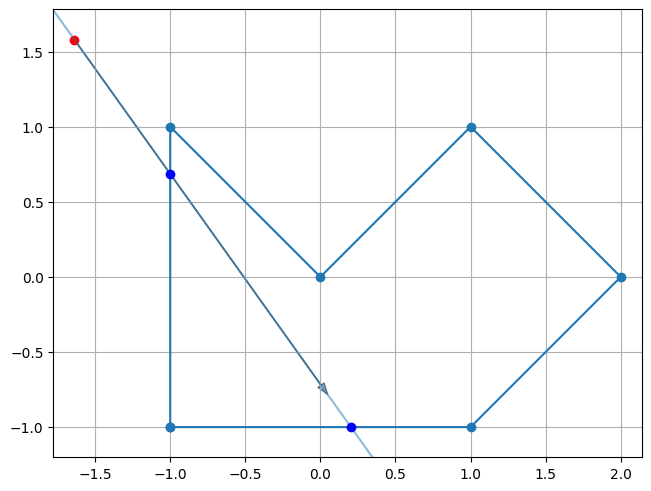

In [14]:

nodes = np.array([[0,0], [2,0], [3, 1], [2,2], [1,1], [0,2]]) - np.array([1,1])
polygon = Polygon(list(nodes))
point = np.random.uniform(-2, 2, size=2)

fig = plt.figure(
        layout="compressed",
        )

ax = fig.add_subplot(
    1, 1, 1,
    aspect="equal",
)

ax.set_xlim(-3, 3, emit=True)
ax.set_ylim(-3, 3, emit=True)

polygon.draw("o-")

plt.plot(*point, 'or')

is_inner, line, points = is_inner_a(polygon, point, True)

print(f"{is_inner=}, {len(points)=}")

plt.axline(line.P1, line.P2, alpha=0.5)
plt.arrow(*line.P1, *(line.P2-line.P1), head_width=0.05, alpha=0.5)

if len(points)>0:
    ax.plot(*np.stack(points, axis=1), 'ob')



ax.grid()
plt.show()


# Sudoku

## Sudoku tábla `Matplotlib`-bel

A cél sudoku solver megírása. Ma csak megjelenítéssel és feladványok beolvasásával foglakozunk.

Ez egy [project Euler](https://projecteuler.net/problem=96) feladat. A teszt adatok is onnan vannak:

https://projecteuler.net/project/resources/p096_sudoku.txt

In [15]:
grid = [[f"{col}{row}" for col in "ABCDEFGHI"] for row in range(9)]
grid

[['A0', 'B0', 'C0', 'D0', 'E0', 'F0', 'G0', 'H0', 'I0'],
 ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'],
 ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2'],
 ['A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3', 'I3'],
 ['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4', 'I4'],
 ['A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5', 'I5'],
 ['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6', 'I6'],
 ['A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7', 'I7'],
 ['A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8', 'I8']]

In [16]:
import uuid

class HTMLGrid:
    css = """
        .sudoku-board, .sudoku-board .box, .sudoku-board .box div {
            box-sizing: border-box;
        }

        .sudoku-board, .sudoku-board .box{
            display: flex;
            flex-wrap: wrap;
        }

        .sudoku-board .box {
           border: solid 1px;
           width: 152px;
        }

        .sudoku-board .box > div {
            border: solid 1px;
            width: 50px;
            text-align: center;
        }

        .sudoku-board .box > div:before {
            display: inline-block;
            padding-top: 100%;
            content: '';
            vertical-align: middle;
        }

        .sudoku-board .box .clue {
            background-color: LightGray;
            font-weight: bold;
        }

        .sudoku-board {
            width: 460px;
            margin: 0px;
            font-size: calc(0.8vw + 10px);
            border: solid 2px;
        }

        .sudoku-board .box div {
            color: gray;
            text-shadow: 1px 1px 1px white;
            vertical-align: middle;
        }
    """

    def __init__(self, transform=None):
        self.transform = self._transform if transform is None else transform

    @staticmethod
    def _transform(val):
        if isinstance(val, str):
            return "", val
        if val < 0:
            return 'class="solved"', -val
        elif val == 0:
            return "", ""
        else:
            return 'class="clue"', val

    def box(self, content):
        inner = "".join(f"<div {div_class}>{val}</div>" for div_class, val in content)
        return f'<div class="box">{inner}</div>\n'

    def board(self, boxes):
        inner = "".join(self.box(box) for box in boxes)
        return f'<div class="sudoku-board">\n{inner}</div>\n'

    def __call__(self, grid, title=""):
        boxes = [[0]*9 for _ in range(9)]
        for i, line in enumerate(grid):
          a, ra = divmod(i, 3)
          for j, val in enumerate(line):
            b, rb = divmod(j, 3)
            boxes[a*3+b][ra*3+rb] = self.transform(val)
        header = f"<h3>{title}</h3>" if title else ""
        html = f"<html>\n<head>\n<style>\n{self.css}\n</style>\n</head>\n<body>\n{header}\n{self.board(boxes)}</body></html>"
        html = html.replace('sudoku-board', f'sudoku-board-{uuid.uuid1()!s}')
        return html


Ellenőrzés EXCEL oszlop-sor jelöléssel

In [18]:
html_grid = HTMLGrid()
grid = [[f'{j}{i}' for j in "ABCDEFGHI"] for i in range(9)]
html = html_grid(grid, "Grid")
print(html)

display_html(html, raw=True)
grid=[
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 0, 0, 3],
    [0, 7, 4, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 2],
    [0, 8, 0, 0, 4, 0, 0, 1, 0],
    [6, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 7, 8, 0],
    [5, 0, 0, 0, 0, 9, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0]
    ]

html = html_grid(grid, "Hard problem")
# print(html)
display_html(html, raw=True)


<html>
<head>
<style>

        .sudoku-board-e3658df2-929a-11ee-895d-0242ac1c000c, .sudoku-board-e3658df2-929a-11ee-895d-0242ac1c000c .box, .sudoku-board-e3658df2-929a-11ee-895d-0242ac1c000c .box div {
            box-sizing: border-box;
        }
        
        .sudoku-board-e3658df2-929a-11ee-895d-0242ac1c000c, .sudoku-board-e3658df2-929a-11ee-895d-0242ac1c000c .box{
            display: flex;
            flex-wrap: wrap;
        }

        .sudoku-board-e3658df2-929a-11ee-895d-0242ac1c000c .box {
           border: solid 1px;
           width: 152px;  
        }
        
        .sudoku-board-e3658df2-929a-11ee-895d-0242ac1c000c .box > div {
            border: solid 1px;
            width: 50px;
            text-align: center;
        }

        .sudoku-board-e3658df2-929a-11ee-895d-0242ac1c000c .box > div:before {
            display: inline-block;
            padding-top: 100%;
            content: '';
            vertical-align: middle;
        }

        .sudoku-board-e3658df

Grid 
 
 A0 B0 C0 A1 B1 C1 A2 B2 C2 
 D0 E0 F0 D1 E1 F1 D2 E2 F2 
 G0 H0 I0 G1 H1 I1 G2 H2 I2 
 A3 B3 C3 A4 B4 C4 A5 B5 C5 
 D3 E3 F3 D4 E4 F4 D5 E5 F5 
 G3 H3 I3 G4 H4 I4 G5 H5 I5 
 A6 B6 C6 A7 B7 C7 A8 B8 C8 
 D6 E6 F6 D7 E7 F7 D8 E8 F8 
 G6 H6 I6 G7 H7 I7 G8 H8 I8

Hard problem 
 
 2 7 4 
 6 8 
 3 
 8 6 
 3 4 5 
 2 1 
 5 
 1 9 
 7 8 4

In [20]:

from IPython.core.pylabtools import print_figure
import matplotlib.pyplot as plt

In [21]:


def figure_data(grid, title="", format="svg"):
    size = len(grid)
    fig = plt.figure(
        figsize=(4, 4),
        layout="compressed",
        )

    ax = fig.add_subplot(
        1, 1, 1,
        aspect="equal",
        xmargin=0.01,
        ymargin=0.01
    )

    ax.axis("off")
    ax.set_title(title, loc="left", fontdict={"weight": "bold"})

    for x, row in enumerate(reversed(grid)):
        for y, value in enumerate(row):
            ax.text(
                y+0.5, x+0.5,
                value,
                ha='center',
                va='center',
                fontsize=12,
                color="gray"
            )

    for x in range(size+1):
        linewidth = 1
        if x % 3 == 0:
            linewidth = 2
        ax.plot((0, size), (x, x), color="black", linewidth=linewidth)
        ax.plot((x, x), (0, size), color="black", linewidth=linewidth)

    data = print_figure(fig, format)
    plt.close(fig)
    return data


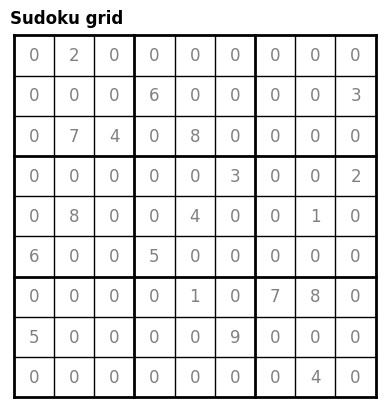

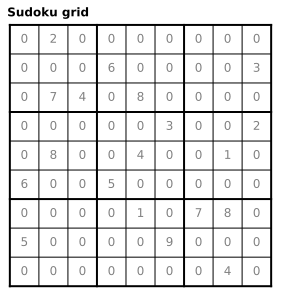

In [22]:
display(Image(figure_data(grid, "Sudoku grid", "png")))
SVG(figure_data(grid, "Sudoku grid", "svg"))

In [24]:
def char_value(x):
    return int(x) if x.isdigit() else 0

class Sudoku:
    html_grid = HTMLGrid()

    def __init__(self, grid, name=None):
        self.grid = grid
        self.name = name if name is not None else "Unnamed Sudoku"
        self._svg_data = None

    @classmethod
    def from_str(cls, grid, name):
        grid = [[char_value(x) for x in line.strip()] for line in grid]
        return cls(grid, name)

    def enumerate(self):
        grid = self.grid
        for row, line in enumerate(grid, 1):
            for col, value in enumerate(line, 1):
                if value != 0:
                    yield row, col, value

    def copy(self):
        grid = [line.copy() for line in self.grid]
        return type(self)(grid, self.name)

    def as_symbols(self, symbols=" 𝟭𝟮𝟯𝟰𝟱𝟲𝟳𝟴𝟵", neg_symbols=" 123456789"):
        return [
            [symbols[abs(x)] if x>=0 else neg_symbols[abs(x)]  for x in line]
            for line in self.grid
            ]

    def txt(self):
        return '\n'.join(map(' '.join, self.as_symbols("_𝟭𝟮𝟯𝟰𝟱𝟲𝟳𝟴𝟵", "_123456789")))

    def __str__(self):
        return f'{self.name}:\n{self.txt()}'

    def _repr_html_(self):
        return self.html_grid(self.grid, self.name)

    def _repr_svg_(self):
        return self.svg

    @property
    def svg(self):
        if self._svg_data is None:
            fig = self.draw()
            self._svg_data = print_figure(fig, fmt="svg")
        return self._svg_data

    def draw(self, **kwargs):
        grid = self.grid
        size = len(grid)
        ax = plt.subplot(1, 1, 1, aspect="equal")
        ax.axis("off")
        ax.set_title(self.name, loc="left", fontdict={"weight": "bold"})

        text_args = {
            'fontsize': "12",
            'color': "gray",
            'ha': 'center',
            'va': 'center'
            }
        text_args.update(kwargs)
        for row, col, value in self.enumerate():
            row = size-row+1
            if value > 0:
                ax.fill([col-1, col, col, col-1], [row-1, row-1, row, row], color="lightgray", alpha=0.5)

            ax.text(
                col-0.5, row-0.5,
                abs(value),
                **text_args,
                fontweight= "bold" if value > 0 else 'normal'
            )

        for x in range(size+1):
            linewidth = 1
            if x % 3 == 0:
                linewidth = 2
            ax.plot((0, size), (x, x), color="black", linewidth=linewidth)
            ax.plot((x, x), (0, size), color="black", linewidth=linewidth)

        plt.close(ax.figure)

        return ax.figure


### Egy nehéz sudoku

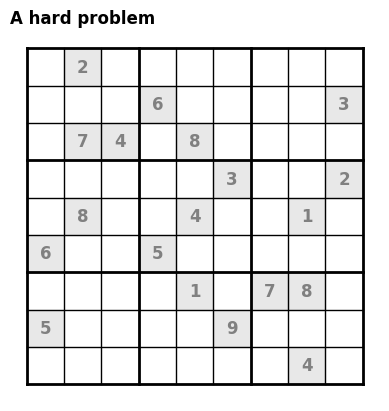

In [75]:
grid=[
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 0, 0, 3],
    [0, 7, 4, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 2],
    [0, 8, 0, 0, 4, 0, 0, 1, 0],
    [6, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 7, 8, 0],
    [5, 0, 0, 0, 0, 9, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0]
    ]
sudoku = Sudoku(grid, "A hard problem")

sudoku.draw()

In [ ]:
print(sudoku)
display(sudoku)
display(SVG(sudoku.svg))


In [ ]:
list(sudoku.enumerate())

## Hogyan fogalmazható meg a feladat a matek eszközeivel?

Adottak követelmények (`Item`) és opciók (`Option`). A feladat az opciók egy részének kiválasztása úgy, hogy az összes követelmény teljesüljön.

Egy lehetséges formalizálás, $x_1,\dots, x_m$ logikai változók, egy
$c=c(x_1,\dots,x_n)$ logikai kifejezés.

A kérdés ezután az, hogy az $x_i$ értékek (Igaz/Hamis) milyen választása mellett lesz a $c$ logikai kifejezés értéke igaz.

Minden logikai kifejezés felírható $\wedge$ (és) $\vee$ (vagy) és $\neg$ (tagadás) segítségével.

pl.
$$
    x_1\Rightarrow x_2,\quad \neg x_1\vee x_2
$$

A logikai kifejezés $c$ megadható olyan alakban is, ahol
$$
    c(x_1,\dots, x_m) = \large\wedge_i c_i(x_1,\dots,x_m)\quad
    c_i(x_1,\dots,x_m) = (\vee_{j\in S_i} x_j) \vee (\vee_{j\in S'_i} \neg x_j),\quad S,S'\subset\{1,\dots, m\}
$$

$c_i$ megadató $S$ és $S'$ segítségével. Ha $S_i\cap S'_i\neq \emptyset$ akkor $c_i$ mindig igaz, ezért $c$-ből elhagyható. Ha a váltózók indexelése 1-től indul, akkor egy kényelmes kódolása $c_i$-nek
az indexek előjeles listája:
$$
    \{j:j \in S_i\}\cup\{-j:j\in S'_i\}
$$


## Sudoku tábla

In [26]:
class Option(int):
    max_value = 9*9*9

    def __init__(self, val):
        if not (1 <= abs(val) <= self.max_value):
            raise ValueError(f"Absolute value must be in [1, {self.max_value}]. Obtained {val}")

    def apply(self, grid):
        row, col, val = self.to_triple()
        row, col = row-1, col-1
        if grid[row][col]!=0 and abs(grid[row][col])!=val:
            raise ValueError("Grid cell at {row+1}, {col+1} is not empty!")
        if grid[row][col] == 0:
            grid[row][col] = -val

    @classmethod
    def from_triple(cls, row, col, val):
        if not (1<= row <= 9 and 1<= col <= 9 and 1<= val <= 9):
            raise ValueError(
                "Invalid triple. "
                "All numbers must be in [1, 9]. "
                f"Obtained {row=}, {col=}, {val=}"
                )
        return cls((row-1)*81+(col-1)*9+val-1 + 1)

    @classmethod
    def instances(cls):
        for i in range(1, cls.max_value+1):
            yield cls(i)

    def to_triple(self):
        n = abs(self)-1
        n, val = divmod(n, 9)
        row, col = divmod(n, 9)
        row, col, val = row+1, col+1, val+1
        return row, col, val

    def __neg__(self):
        return Option(-int(self))

    def __str__(self):
        row, col, val = self.to_triple()
        prefix = 'not ' if self < 0 else ''
        return f"{prefix}{val}@({row}, {col})"

    def __repr__(self):
        return f"{type(self).__name__}({self!s}, code={self:d})"

    def items(self):
        row, col, val = self.to_triple()
        yield Item.not_empty(row, col)
        yield Item.row_contains(row, val)
        yield Item.col_contains(col, val)
        yield Item.square_contains(row, col, val)


class Clause(list):
    def __str__(self):
        return ' or '. join(map(str, self))

In [27]:
%%ipytest
from pytest import raises

def test_option():
    for i in range(1, 10):
        for j in range(1, 10):
            for val in range(1,10):
                option = Option.from_triple(i, j, val)
                assert str(option) == f"{val}@({i}, {j})"
                assert option.to_triple() == (i, j, val)

def test_option_invalid():
    with raises(ValueError):
        option = Option.from_triple(10,9,9)

    with raises(ValueError):
        option = Option.from_triple(0,9,9)

    with raises(ValueError):
        option = Option.from_triple(1,10,9)

    with raises(ValueError):
        option = Option.from_triple(1,0,9)

    with raises(ValueError):
        option = Option.from_triple(1,9,19)

    with raises(ValueError):
        option = Option.from_triple(1,9,0)

def test_option_all():
    for i, o in enumerate(Option.instances(), 1):
        assert o == i
    assert i == Option.max_value



...                                                                                          [100%]
3 passed in 0.04s


In [28]:
-Option.from_triple(1,1,9)

Option(not 9@(1, 1), code=-9)

In [29]:
def subsquare(i, j):
    x, y = 3*i+1, 3*j+1
    for row in range(x, x+3):
        for col in range(y, y+3):
            yield row, col

class Item(int):
    max_value = 4*9*9-1


    def __init__(self, value):
        if not (0 <= value <= self.max_value):
            raise ValueError(f"Value must be in [0, max_value]. Obtained {value}")

    @classmethod
    def from_triple(cls, item_type, a, b):
        if not (0 <= item_type < 4 and 0 <= a < 9 and 0 <= b < 9):
            raise ValueError(f"Invalid parameters: {item_type=}, {a=}, {b=}")
        return cls(item_type*81+a*9+b)

    @classmethod
    def not_empty(cls, row, col):
        return cls.from_triple(0, row-1, col-1)

    @classmethod
    def row_contains(cls, row, val):
        return cls.from_triple(1, row-1, val-1)

    @classmethod
    def col_contains(cls, col, val):
        return cls.from_triple(2, col-1, val-1)

    @classmethod
    def square_contains(cls, row, col, val):
        sq = 3*((row-1)//3) + ((col-1)//3)
        return cls.from_triple(3, sq, val-1)

    @classmethod
    def instances(cls):
        for i in range(cls.max_value+1):
            yield cls(i)

    def __str__(self):
        n = self
        item_type, n = divmod(n, 81)
        i, j = divmod(n, 9)
        match item_type:
            case 0:
                return f"cell{(i+1, j+1)} ¬∅"
            case 1:
                return f"∃{j+1} in row[{i+1}]"
            case 2:
                return f"∃{j+1} in col[{i+1}]"
            case 3:
                val = j+1
                i, j = divmod(i, 3)
                return f"∃{val} in square{(i+1, j+1)}"

    def __repr__(self):
        return f"{type(self).__name__}({self!s}, code={self:d})"

    def options(self):
        n = self
        item_type, n = divmod(n, 81)
        i, j = divmod(n, 9)
        match item_type:
            case 0:
                row, col = i+1, j+1
                for val in range(1, 10):
                    yield Option.from_triple(row, col, val)
            case 1:
                row = i+1
                val = j+1
                for col in range(1, 10):
                    yield Option.from_triple(row, col, val)
            case 2:
                val = j+1
                col = i+1
                for row in range(1, 10):
                    yield Option.from_triple(row, col, val)
            case 3:
                val = j+1
                i, j = divmod(i, 3)
                for row,col in subsquare(i, j):
                    yield Option.from_triple(row, col, val)

    def cnf(self):
        return Clause(self.options())


In [31]:

item = Item(81*3+45)
print(f"{item=}")
print(item.cnf())
pprint(set(item.options()))
print(f"{len(list(Item.instances()))=}")

item=Item(∃1 in square(2, 3), code=288)
1@(4, 7) or 1@(4, 8) or 1@(4, 9) or 1@(5, 7) or 1@(5, 8) or 1@(5, 9) or 1@(6, 7) or 1@(6, 8) or 1@(6, 9)
{Option(1@(4, 7), code=298),
 Option(1@(4, 8), code=307),
 Option(1@(4, 9), code=316),
 Option(1@(5, 7), code=379),
 Option(1@(5, 8), code=388),
 Option(1@(5, 9), code=397),
 Option(1@(6, 7), code=460),
 Option(1@(6, 8), code=469),
 Option(1@(6, 9), code=478)}
len(list(Item.instances()))=324


In [32]:
print(Clause([Option(1), Option(2), -Option(3)]))

1@(1, 1) or 2@(1, 1) or not 3@(1, 1)


In [ ]:
option = Option(100)
print(f"{option=}")
pprint(list(option.items()))

## Sudoku solver a `picosat` könyvtárral.

A következő kód a `picosat` solver `github` repositorijáról van:

https://pypi.org/project/pycosat/

https://github.com/conda/pycosat/blob/main/examples/sudoku.py

```python
"""
The implementation of this Sudoku solver is based on the paper:

    "A SAT-based Sudoku solver" by Tjark Weber

    https://www.lri.fr/~conchon/mpri/weber.pdf

If you want to understand the code below, in particular the function valid(),
which calculates the 324 clauses corresponding to 9 cells, you are strongly
encouraged to read the paper first.  The paper is very short, but contains
all necessary information.
"""
import pycosat


def v(i, j, d):
    """
    Return the number of the variable of cell i, j and digit d,
    which is an integer in the range of 1 to 729 (including).
    """
    return 81 * (i - 1) + 9 * (j - 1) + d


def sudoku_clauses():
    """
    Create the (11745) Sudoku clauses, and return them as a list.
    Note that these clauses are *independent* of the particular
    Sudoku puzzle at hand.
    """
    res = []
    # for all cells, ensure that the each cell:
    for i in range(1, 10):
        for j in range(1, 10):
            # denotes (at least) one of the 9 digits (1 clause)
            res.append([v(i, j, d) for d in range(1, 10)])
            # does not denote two different digits at once (36 clauses)
            for d in range(1, 10):
                for dp in range(d + 1, 10):
                    res.append([-v(i, j, d), -v(i, j, dp)])

    def valid(cells):
        # Append 324 clauses, corresponding to 9 cells, to the result.
        # The 9 cells are represented by a list tuples.  The new clauses
        # ensure that the cells contain distinct values.
        for i, xi in enumerate(cells):
            for j, xj in enumerate(cells):
                if i < j:
                    for d in range(1, 10):
                        res.append([-v(xi[0], xi[1], d), -v(xj[0], xj[1], d)])

    # ensure rows and columns have distinct values
    for i in range(1, 10):
        valid([(i, j) for j in range(1, 10)])
        valid([(j, i) for j in range(1, 10)])
    # ensure 3x3 sub-grids "regions" have distinct values
    for i in 1, 4, 7:
        for j in 1, 4 ,7:
            valid([(i + k % 3, j + k // 3) for k in range(9)])

    assert len(res) == 81 * (1 + 36) + 27 * 324
    return res


def solve(grid):
    """
    solve a Sudoku grid inplace
    """
    clauses = sudoku_clauses()
    for i in range(1, 10):
        for j in range(1, 10):
            d = grid[i - 1][j - 1]
            # For each digit already known, a clause (with one literal).
            # Note:
            #     We could also remove all variables for the known cells
            #     altogether (which would be more efficient).  However, for
            #     the sake of simplicity, we decided not to do that.
            if d:
                clauses.append([v(i, j, d)])

    # solve the SAT problem
    sol = set(pycosat.solve(clauses))

    def read_cell(i, j):
        # return the digit of cell i, j according to the solution
        for d in range(1, 10):
            if v(i, j, d) in sol:
                return d

    for i in range(1, 10):
        for j in range(1, 10):
            grid[i - 1][j - 1] = read_cell(i, j)


if __name__ == '__main__':
    from pprint import pprint

    # hard Sudoku problem, see Fig. 3 in paper by Weber
    hard = [[0, 2, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 6, 0, 0, 0, 0, 3],
            [0, 7, 4, 0, 8, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 3, 0, 0, 2],
            [0, 8, 0, 0, 4, 0, 0, 1, 0],
            [6, 0, 0, 5, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 7, 8, 0],
            [5, 0, 0, 0, 0, 9, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 4, 0]]
    solve(hard)
    pprint(hard)
    assert [[1, 2, 6, 4, 3, 7, 9, 5, 8],
            [8, 9, 5, 6, 2, 1, 4, 7, 3],
            [3, 7, 4, 9, 8, 5, 1, 2, 6],
            [4, 5, 7, 1, 9, 3, 8, 6, 2],
            [9, 8, 3, 2, 4, 6, 5, 1, 7],
            [6, 1, 2, 5, 7, 8, 3, 9, 4],
            [2, 6, 9, 3, 1, 4, 7, 8, 5],
            [5, 4, 8, 7, 6, 9, 2, 3, 1],
            [7, 3, 1, 8, 5, 2, 6, 4, 9]] == hard

```

In [34]:
import pycosat
from itertools import product, combinations


In [35]:
def sudoku_clauses_naive():
    one_value_per_cell = [
        Clause((-Option.from_triple(row, col, val0), -Option.from_triple(row, col, val1)))
        for row, col, (val0, val1) in product(
            range(1, 10),
            range(1, 10),
            combinations(range(1, 10), 2)
        )
    ]

    return (
        [Item(i).cnf() for i in range(4*81)] +
        one_value_per_cell
    )

In [36]:

def sudoku_clauses():
    one_value_per_cell = [
        Clause((-Option.from_triple(row, col, val0), -Option.from_triple(row, col, val1)))
        for row, col, (val0, val1) in product(
            range(1, 10),
            range(1, 10),
            combinations(range(1, 10), 2)
        )
    ]

    one_location_per_row = [
        Clause((-Option.from_triple(row, col0, val), -Option.from_triple(row, col1, val)))
        for row, (col0, col1), val in product(
            range(1, 10),
            combinations(range(1, 10), 2),
            range(1, 10),
        )
    ]

    one_location_per_col = [
        Clause((-Option.from_triple(row0, col, val), -Option.from_triple(row1, col, val)))
        for (row0, row1), col, val in product(
            combinations(range(1, 10), 2),
            range(1, 10),
            range(1, 10)
        )
    ]

    one_location_per_square = [
        Clause((-Option.from_triple(row0, col0, val), -Option.from_triple(row1, col1, val)))
        for i in range(9)
        for ((row0, col0), (row1, col1)), val in product(
            combinations(subsquare(i//3, i%3), 2),
            range(1, 10)
        )
    ]

    return (
        [Item(i).cnf() for i in range(4*81)] +
        one_value_per_cell +
        one_location_per_row +
        one_location_per_col +
        one_location_per_square
    )

In [37]:
clauses = sudoku_clauses_naive()
print(f"{len(clauses)=}\n {clauses[0]=!s}\n {clauses[-5]=!s}")

len(clauses)=3240
 clauses[0]=1@(1, 1) or 2@(1, 1) or 3@(1, 1) or 4@(1, 1) or 5@(1, 1) or 6@(1, 1) or 7@(1, 1) or 8@(1, 1) or 9@(1, 1)
 clauses[-5]=not 6@(9, 9) or not 8@(9, 9)


In [38]:
def naive_solver(sudoku, **kwargs):
    """
    solve a Sudoku grid inplace
    """
    clauses = sudoku_clauses_naive()

    clauses.extend(
        Clause([Option.from_triple(row, col, val)])
        for row, col, val in sudoku.enumerate()
    )

    sudoku_solved = sudoku.copy()
    grid = sudoku_solved.grid
    for option in pycosat.solve(clauses, **kwargs):
        if option > 0:
            Option(option).apply(grid)
    sudoku_solved.name += " solved"
    return sudoku_solved

In [39]:
def modified_solver(sudoku, **kwargs):
    """
    solve a Sudoku grid inplace
    """
    clauses = sudoku_clauses()

    clauses.extend(
        Clause([Option.from_triple(row, col, val)])
        for row, col, val in sudoku.enumerate()
    )

    sudoku_solved = sudoku.copy()
    grid = sudoku_solved.grid
    for option in pycosat.solve(clauses, **kwargs):
        if option > 0:
            Option(option).apply(grid)
    sudoku_solved.name += " solved"
    return sudoku_solved


In [40]:
class PycosatSolver:
    naive_clauses = sudoku_clauses_naive()
    clauses = sudoku_clauses()
    def solve(self, sudoku, which="modified", **kwargs):
        clauses = self.clauses if which == "modified" else self.naive_clauses
        clauses = clauses.copy()
        clauses.extend(
            Clause([Option.from_triple(row, col, val)])
            for row, col, val in sudoku.enumerate()
        )
        sudoku_solved = sudoku.copy()
        grid = sudoku_solved.grid
        for option in pycosat.solve(clauses, **kwargs):
            if option > 0:
                Option(option).apply(grid)
        sudoku_solved.name += " solved"
        return sudoku_solved



In [41]:
%timeit sudoku_solved = naive_solver(sudoku)

1.32 s ± 185 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%timeit sudoku_solved = modified_solver(sudoku)

57.2 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
sudoku_solved = modified_solver(sudoku)
print(sudoku_solved)

A hard problem solved:
1 𝟮 6 4 3 7 9 5 8
8 9 5 𝟲 2 1 4 7 𝟯
3 𝟳 𝟰 9 𝟴 5 1 2 6
4 5 7 1 9 𝟯 8 6 𝟮
9 𝟴 3 2 𝟰 6 5 𝟭 7
𝟲 1 2 𝟱 7 8 3 9 4
2 6 9 3 𝟭 4 𝟳 𝟴 5
𝟱 4 8 7 6 𝟵 2 3 1
7 3 1 8 5 2 6 𝟰 9


In [ ]:
display(SVG(sudoku_solved.svg))

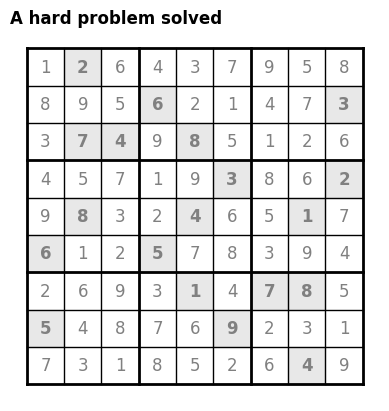

In [44]:
sudoku_solved.draw()

## Egész értékű programozás

A sudoku feladat úgy is megfogalmazható, hogy adott egy mátrix $A$. $A_{i,j}=1$ ha az $j$. opció kielégíti a $i$. követelményt. A korábbi $x_1,\dots,x_m$ logikai változókat egy $x$ vektorba összefogva ($\text{Hamis}=0$ és $\text{Igaz}=1$)
$$
    v = Ax
$$
esetén $v_i$ azt adja meg, hogy a $i$. követelményt hány opció teljesíti a kiválasztottak közül. Azt szeretnénk, ha ez 1 lenne minden $i$-re.

Azaz a feladat
$$
    Ax = \mathbb{1}, \quad \text{úgy, hogy  $x_i\in\{0, 1\}$}
$$
Ha több megoldás van akkor vehetjük azt, ami minimalizál egy lineráris kifejezést.

## Lineáris programozás

A lineáris programozási feladat általános alakja:
$$
    x_0=\arg\max_x c^T x,\quad\text{úgy, hogy}\quad
    Ax \leq b, \quad x\geq0
$$
Azaz azt az $x_0$ vektort keressük, ami a $\sum_jc_jx_j$ összeget maximalizálja azon nem negatív koordinátájú $x$-ek között, amik a lineáris feltételnek $(Ax)_j\geq 0$ eleget tesznek.

A feladatban $A$, $c$ és $b$ adottak és $c$, $b$ **nem negatívak** (azaz a koordináták ilyenek).

Példa:

In [46]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
c = np.array([1, 1])
b = np.array([2, 3])
A = np.array([[1, 2], [2, 1]])
print(f"{c=}, {b=},\n{A=!s}")

c=array([1, 1]), b=array([2, 3]),
A=[[1 2]
 [2 1]]


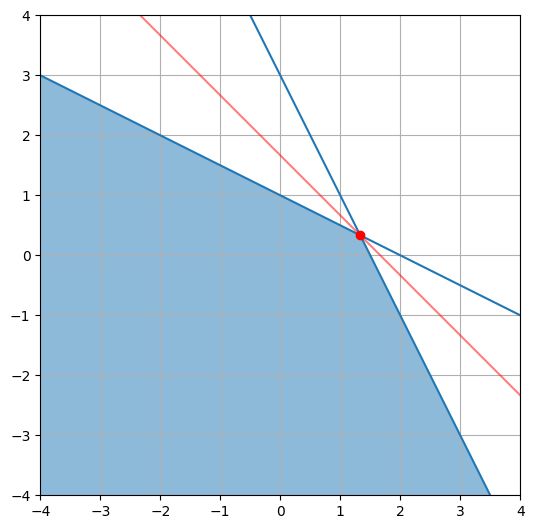

In [48]:
def line(v, b):
    p0 = b/(v@v)*v
    v_perp = np.array([v[1], -v[0]])
    p1 = p0+v_perp
    return p0, p1

def y_fun(v, b):
    return lambda x: b/v[1]-(v[0]/v[1])*x

ax = plt.axes((0, 0, 1, 1))
ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))
ax.set_aspect("equal")
for v, b0 in zip(A, b):
    ax.axline(*line(v, b0))
ax.grid()
ax.plot([4/3], [1/3], 'or')
ax.axline((4/3, 1/3), (1/3, 4/3), color='red', alpha=0.5)


xs = np.linspace(-4, 4, 201)

ax.fill_between(xs, -4, np.minimum(y_fun(A[0], b[0])(xs), y_fun(A[1], b[1])(xs)), alpha=0.5)
plt.show()


## `scipy` mixed integer solver (`milp`).

In [49]:
from scipy.optimize import milp, Bounds, LinearConstraint
import numpy as np

In [50]:
help(milp)

Help on function milp in module scipy.optimize._milp:

milp(c, *, integrality=None, bounds=None, constraints=None, options=None)
    Mixed-integer linear programming
    
    Solves problems of the following form:
    
    .. math::
    
        \min_x \ & c^T x \\
        \mbox{such that} \ & b_l \leq A x \leq b_u,\\
        & l \leq x \leq u, \\
        & x_i \in \mathbb{Z}, i \in X_i
    
    where :math:`x` is a vector of decision variables;
    :math:`c`, :math:`b_l`, :math:`b_u`, :math:`l`, and :math:`u` are vectors;
    :math:`A` is a matrix, and :math:`X_i` is the set of indices of
    decision variables that must be integral. (In this context, a
    variable that can assume only integer values is said to be "integral";
    it has an "integrality" constraint.)
    
    Alternatively, that's:
    
    minimize::
    
        c @ x
    
    such that::
    
        b_l <= A @ x <= b_u
        l <= x <= u
        Specified elements of x must be integers
    
    By default, ``l = 

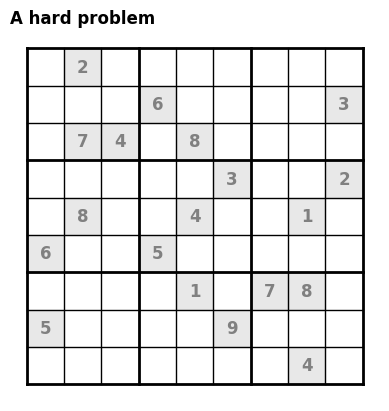

In [51]:
sudoku.draw()

In [52]:
def sudoku_adj_matrix():
    options = list(Option.instances())

    A = np.zeros((Item.max_value+1, len(options)))
    for j, option in enumerate(options):
        for item in option.items():
            A[item][j] = 1
    return A, options


In [53]:
A, options = sudoku_adj_matrix()
pprint(A)

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])


In [54]:

class MilpSolver():
    A, options = sudoku_adj_matrix()
    options_ub = np.ones_like(options)
    items_b = np.ones(A.shape[0])

    def solve(self, sudoku):
        lower_bound = np.zeros_like(self.options_ub)

        lower_bound[
            [Option.from_triple(row, col, val)-1 for row, col, val in sudoku.enumerate()]
            ] = 1
        bounds = Bounds(lower_bound, self.options_ub)
        constraints = LinearConstraint(self.A, self.items_b, self.items_b)
        solution = milp(
            self.options_ub, # all one vector, could be almost anything
            integrality=self.options_ub,
            bounds=bounds,
            constraints=constraints
            )
        sudoku_solved = sudoku.copy()
        sudoku_solved.name += " solved"
        for option, include in zip(self.options, solution.x):
            if include == 1:
                option.apply(sudoku_solved.grid)

        sudoku_solved.milp_solution = solution
        return sudoku_solved





In [55]:
milp_solver = MilpSolver()
sudoku_solved = milp_solver.solve(sudoku)

In [56]:
%timeit sudoku_solved = milp_solver.solve(sudoku)


13.8 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 81.0
              x: [ 1.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
 mip_node_count: 0
 mip_dual_bound: 81.0
        mip_gap: 0.0


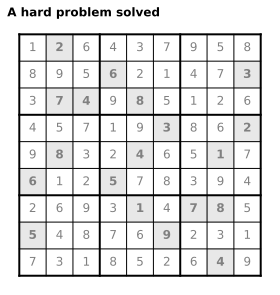

In [57]:
print(sudoku_solved.milp_solution)
sudoku_solved

In [ ]:
print(sudoku_solved)

## Google `OR-tools` (operation research tools)

In [ ]:
if importlib.util.find_spec('ortools') is None:
    ! pip install ortools


Ezzel is megoldhatnánk. HF.

## Feladványok a netről

In [58]:
import urllib

In [59]:
dowload_large = False #or True

url50 = "https://projecteuler.net/project/resources/p096_sudoku.txt"

urllib.request.urlretrieve(url50, "/tmp/sudoku.txt")


url50000 = "https://github.com/t-dillon/tdoku/raw/master/data.zip"

if dowload_large:
    urllib.request.urlretrieve(url50000, "/tmp/sudoku-large.zip")



In [60]:
if dowload_large:
    ! unzip -l /tmp/sudoku-large.zip
    ! unzip -q /tmp/sudoku-large.zip data/puzzles2_17_clue

In [61]:
def drop_comment(file):
    while True:
        try:
            line = next(file).strip()
        except EOFError:
            return
        if not line.startswith("#"):
            yield line

In [62]:
if dowload_large:
    with open('data/puzzles2_17_clue', 'r') as file:
        line = next(drop_comment(file))
        grid = [[int(ch) if ch.isdigit() else 0 for ch in line[i: i+9]] for i in range(0,81,9)]
        sudoku = Sudoku(grid)
    sudoku

In [63]:
with open('/tmp/sudoku.txt') as f:
    name = f.readline().strip()
    grid = [f.readline() for _ in range(9)]
    sudoku = Sudoku.from_str(grid, name)

In [64]:
def read_sudokus(filename):
    with open(filename, "r") as file:
        lines = iter(file)
        while True:
            try:
                name = next(lines).strip()
                grid = [next(lines) for _ in range(9)]
            except StopIteration:
                break
            yield Sudoku.from_str(grid, name)

In [65]:
from tqdm.auto import tqdm

In [66]:
sudokus = list(read_sudokus("/tmp/sudoku.txt"))

In [67]:
%%time

sudoku_milp = MilpSolver()
solved_milp = [sudoku_milp.solve(sudoku) for sudoku in tqdm(sudokus)]


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 366 ms, sys: 8.56 ms, total: 374 ms
Wall time: 384 ms


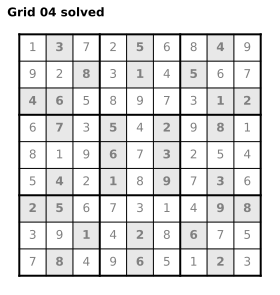

In [68]:
solved_milp[3]

In [69]:
sudokus = list(read_sudokus("/tmp/sudoku.txt"))

In [70]:
%%time

pycosat_solver = PycosatSolver()
solved_picosat = [pycosat_solver.solve(sudoku) for sudoku in tqdm(sudokus)]



  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 252 ms, sys: 5.35 ms, total: 257 ms
Wall time: 271 ms


In [71]:
sudokus = list(read_sudokus("/tmp/sudoku.txt"))

In [72]:
%%time

pycosat_solver = PycosatSolver()
solved_naive = [pycosat_solver.solve(sudoku, "naive") for sudoku in tqdm(sudokus)]


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 7.07 s, sys: 13.7 ms, total: 7.08 s
Wall time: 7.24 s


## Saját solver


A Sudokuban ki kell tölteni a hiányzó mezőket úgy, hogy minden sor, oszlop és a 9 db 3x3-as négyzet mindegyike tartalmazza az összes számot egytől kilencig.

Minden oszlop, sor és kis négyzet kilenc követelményt jelent nevezetesen azt, hogy az adott tábla részen kell, hogy legyen $1,...,9$.
Ez összesen $3*9*9$ követelmény. További követlemény, hogy minden mező pontosan egy értéket tartalmazhat. Ez további 81 követelmény, így összesen $4*9*9$
követelmény van.

Minden cellába írhatjuk a 9 szám bármelyikét ez összesen $9*9*9$ opció.

Minden opció ki tud elégíteni néhány követelményt, pl. ha az opció az hogy (1,1) mezőben 2 van, akkor ha ezt az opciót kiválasztjuk, azzal teljesülni fog,
hogy az első sorban, első oszlopban és az (1,1) tartalmazó 3x3-as négyzetben is van 2-es.

A feladványt, akkor oldottuk meg, ha kiválasztottuk az opciók egy részét úgy, hogy minden követelményt pontosan egy opció teljesít a kiválasztottak közül.


Kicsit messzebről ránézve, van egy páros gráfunk. A csúcsok egyik csoportja a követelményekből, a másik az opciókból áll. Egy követelmény és egy opció között akkor megy él, ha az adott opció kiválasztásával kielégítjük a követelményt.

A cél opciók egy részének kiválasztása úgy, hogy minden követelménynek pontosan egy szomszédja legyen a kiválasztott opciók között (exact cover).

A megoldás megtalálása elméletben egyszerű.

1. `G` a játék gráfja (mátrixa). Töröljük azokat az opciókat, amik összegyeztethetelenek a kitöltött mezőkkel.
2. Válasszunk egy `item` követelményt.
3. A `item` szomszédjait ellenőrizzük le. Azaz menjünk végig azokon az opciókon, amik `item`-et kielégítik:
   
   - Mindegyik opcióra  készítsük el azt a  kisebb gráfot, amit úgy kapunk, hogy a kiválsztott opciót
     beírjuk a táblába.
   
     Így néhány további követelményt is kielégítünk és néhány opciót el is kell hagynunk.

   - Oldjuk meg a kisebb gráffal a feladatot:
     
     Ha a kisebb feladatnak nincs megoldása, a kiválasztott opcióval nem lehet megoldani a problémát.
     Nézzük a következő lehetőséget.

     Ha a kisebb feladatnak van megoldása, akkor a feladat megoldása a kiválasztott opció és a kisebb probléma megoldása együtt.

Lehet, hogy kóddal leírva könnyebben érthető.

```python
def search(G):
    if G.items:
      item = first_item(G.items)
      for option in G.options[item]:
            solution = search(new_graph(G, option))
            if solution is not None:
                return (option,) + solution
      return None
    return tuple()
```

Itt `new_graph(G, option)` visszaadja a gráfot amit úgy kapunk, hogy
`option` által kielégített követelményeket  és azokat az opciókat amik `option`-nal összeegyeztethetlenek elhagyjuk.

Azt feltételezzük, hogy a `new_graph` függvény nem módosítja `G`-t a visszaadott gráf másolat.


A futási idő attól függ, hogyan választjuk ki követelményt. A legegyszerűbb módszer: vegyük azt amihez aktuálisan a legkevesebb opció tartozik.
Ez pont annak felel meg, amit a játék során magunk is csinálnánk, pl ha egy mezőbe csak egy lehetőség maradt az kitöltjük.

In [73]:
def sudoku_graph():
    options = {option: list(option.items()) for option in Option.instances()}
    items = {item: set(item.options()) for item in Item.instances()}
    return options, items


def new_graph(graph, option):
    options, items = graph
    items_covered = [item for item in options[option] if item in items]
    conflicting_options = set(o for item in items_covered for o in items[item])
    new_options = {
        key: [item for item in value if item not in items_covered]
        for key, value in options.items()
        if key not in conflicting_options
    }
    new_items = {
        key: [opt for opt in value if opt not in conflicting_options]
        for key, value in items.items()
        if key not in items_covered
    }
    return new_options, new_items

def first_item(items):
    return min(items, key=lambda item: len(items[item]))

def search(graph):
    _, items = graph
    if items:
        item = first_item(items)
        for option in items[item]:
            solution = search(new_graph(graph, option))
            if solution is not None:
                return (option,) + solution
        return None
    return tuple()

def initial_graph(sudoku):
    graph = sudoku_graph()
    for row, col, val in sudoku.enumerate():
        option = Option.from_triple(row, col, val)
        graph = new_graph(graph, option)
    return graph

def sudoku_solver(sudoku):
    graph = initial_graph(sudoku)

    solution = search(graph)
    if solution is None:
        return None

    sudoku_solved = sudoku.copy()
    for option in solution:
        option.apply(sudoku_solved.grid)
    return sudoku_solved


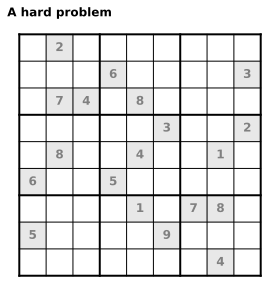

In [76]:
sudoku

In [ ]:
options, items = initial_graph(sudoku)

In [ ]:
# pprint(items)

In [78]:

%timeit sudoku_solved = sudoku_solver(sudoku)

79.4 ms ± 408 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


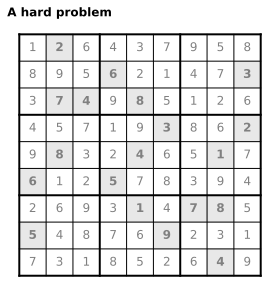

In [79]:
sudoku_solved = sudoku_solver(sudoku)
sudoku_solved

### Logging. Megoldás lépésről lépésre

In [80]:
import logging
logger = logging.getLogger('sudoku')
logging.basicConfig()
logger.setLevel(logging.WARNING)


In [81]:

def search(graph):
    _, items = graph
    if items:
        item = first_item(items)
        logger.info('considering %s', item)

        for option in items[item]:
            logger.info('trying %s', option)
            solution = search(new_graph(graph, option))
            if solution is not None:
                logger.info('%s works', option)
                return (option,) + solution
            logger.info('%s rejected', option)
        return None
    return tuple()

In [ ]:
# logger.setLevel(logging.DEBUG)

In [82]:
from contextlib import contextmanager

@contextmanager
def using_level(level):
    logger = logging.getLogger('sudoku')
    _level = logger.level
    try:
        logger.setLevel(level)
        yield
    finally:
        logger.setLevel(_level)

In [83]:
sudoku_solved = sudoku_solver(sudoku)


In [84]:
with using_level(logging.INFO):
    sudoku_solved = sudoku_solver(sudoku)


INFO:sudoku:considering ∃6 in square(1, 1)
INFO:sudoku:trying 6@(1, 3)
INFO:sudoku:considering cell(8, 9) ¬∅
INFO:sudoku:trying 1@(8, 9)
INFO:sudoku:considering ∃4 in row[2]
INFO:sudoku:trying 4@(2, 6)
INFO:sudoku:considering ∃4 in row[1]
INFO:sudoku:trying 4@(1, 9)
INFO:sudoku:considering ∃8 in col[9]
INFO:sudoku:trying 8@(6, 9)
INFO:sudoku:considering ∃8 in row[4]
INFO:sudoku:trying 8@(4, 4)
INFO:sudoku:considering ∃8 in row[8]
INFO:sudoku:trying 8@(8, 3)
INFO:sudoku:considering ∃8 in row[9]
INFO:sudoku:trying 8@(9, 6)
INFO:sudoku:considering ∃7 in col[9]
INFO:sudoku:trying 7@(5, 9)
INFO:sudoku:considering ∃1 in square(2, 2)
INFO:sudoku:trying 1@(6, 6)
INFO:sudoku:considering ∃7 in col[6]
INFO:sudoku:trying 7@(1, 6)
INFO:sudoku:considering ∃7 in row[2]
INFO:sudoku:trying 7@(2, 8)
INFO:sudoku:considering cell(1, 8) ¬∅
INFO:sudoku:trying 5@(1, 8)
INFO:sudoku:considering ∃5 in row[3]
INFO:sudoku:trying 5@(3, 6)
INFO:sudoku:considering ∃5 in row[7]
INFO:sudoku:trying 5@(7, 9)
INFO:sudoku

In [ ]:
sudokus = list(read_sudokus("/tmp/sudoku.txt"))

In [ ]:
solutions = [sudoku_solver(sudoku) for sudoku in tqdm(sudokus)]

A fenti módszer mindig lemásolja a maradék gráfot és azon dolgozik tovább. [Knuth __Dancing Link__](https://arxiv.org/abs/cs/0011047)-nek nevezett módszerével a másolások elkerülhetőek, és valamivel gyorsabb lenne a számolás.


# Ha maradna idő

## Feladatok előadásról

### Ismétlődések törlése


Egy adott sztringből távolítsuk el az egymás mellett álló ismétlődő karatereket.

Példa:
```
"kukkkuuuurrrriiiikuuuuuuuu" -> "kukuriku".
```

(Ez már volt korábban. Most keressünk elegánsabb megoldást, pl. az `itertools` könyvtár függvényeinek segítségével.)


In [ ]:

def remove_consecutive_duplicates(string):
    pass


### Számolás polinomokkal

Írjunk egy `Polynomial` osztályt, ahol a polinomot tároljuk el, mint az együtthatóinak listáját.

Implementáljuk két ilyen polinom összeadását (azaz írjuk meg az `__add__`, valamint a `__repr__`  metódust, hogy lássuk, mi egy ilyen egyed ,,tartalma'').

Egy polinom függvény is. Implementáljuk a `__call__` metódust is, ami kiértékeli a polinomot egy adott pontban!


In [ ]:
from itertools import dropwhile
from fractions import Fraction


In [ ]:
def format_term(k, coeff, fmt="x^{k}"):
    sep = "-" if coeff < 0 else "+"
    coeff = abs(coeff)
    c = f"{coeff}" if coeff != 1 else ""
    match k:
        case 0:
            x = ""
            c = f"{coeff}"
        case 1:
            x = "x"
        case _:
            x = fmt.format(k=k)
    return f"{c}{x}", sep

class Polynomial:
    def __init__(self, *coefficients):
        self.coeff = tuple(dropwhile(lambda x: x==0, coefficients))[::-1]

    def degree(self):
        return len(self.coeff)-1 if self.coeff else 0

    def __eq__(self, other):
        return isinstance(other, type(self)) and self.coeff == other.coeff

    def __add__(self, other):

        coeff_a = self.coeff
        coeff_b = other.coeff

        if len(coeff_a) < len(coeff_b):
            coeff_a, coeff_b = coeff_b, coeff_a

        coeff = list(coeff_a)

        for i, c in enumerate(coeff_b):
            coeff[i] += c

        return Polynomial(*reversed(coeff))

    def __sub__(self, other):
        return self+(-1)*other

    def __mul__(self, other):
        coeff = [0]*(len(self.coeff)+len(other.coeff)-1)
        for i, ca in enumerate(self.coeff):
            for j, cb in enumerate(other.coeff):
                coeff[i+j] += ca*cb

        return Polynomial(*reversed(coeff))

    def __rmul__(self, c):
        coeff = [c0*c for c0 in self.coeff]
        return Polynomial(*reversed(coeff))

    def leading_coeff(self):
        return self.coeff[-1] if self.coeff else 0

    def __divmod__(self, other):
        if not isinstance(other, type(self)):
            raise TypeError

        m = Polynomial()
        r = self
        main_coeff = other.leading_coeff()
        other_dg = other.degree()

        while r.degree() >= other_dg:
            c = r.leading_coeff()/main_coeff
            m += c*monomial(r.degree()-other_dg)
            r = self-m*other
        return m, r

    def __mod__(self, other):
        return divmod(self, other)[1]

    def __floordiv__(self, other):
        return divmod(self, other)[0]

    def __call__(self, x):
        value = 0
        for c in reversed(self.coeff):
            value *= x
            value += c
        return value

    def as_token_list(self, formatter, fmt):
        coeffs = [(k, coeff) for k, coeff in enumerate(self.coeff) if coeff != 0]
        if len(coeffs) == 0:
            coeffs = [(0, 0)]
        tokens = [token for k, coeff in coeffs for token in format_term(k, coeff, fmt)]
        if tokens[-1] == "+":
            tokens.pop()
        tokens.reverse()
        return tokens

    def __str__(self):
        return ''.join(self.as_token_list(format_term, "x^{k}"))

    def __repr__(self):
        return f"{type(self).__name__}({', '.join(map(str, reversed(self.coeff)))})"

    def _repr_latex_(self):
        formula = ''.join(self.as_token_list(format_term, "x^{{{k}}}"))
        return f"$x\mapsto {formula}$"


def monomial(degree, unit=1):
    coeff = [unit]+[0]*degree
    return Polynomial(*coeff)

Néhány példa:

In [ ]:
p = Polynomial(-1, -0.0, -3)    # -> x^2 - 3
q = Polynomial(2, 0, -1, 1)  # -> 2x^3 + 3x + 1
display(p)
display(q)
display(p*q)
display(2*p)
print(str(q))
## p**2

In [ ]:
p = Fraction(1,1)*p
q = Fraction(1,1)*q

m, r = divmod(q, p)
display(m)
display(r)
display(p)
display(q)
display(m*p)

#### Korábbi feladat

Írjunk egy függvényt, ami kiszámolja az első $n$ természetes szám $p$-ik hatványösszegét.

pl. `p = 0`-ra

```Python
def f0(n):
    return n
```

jó, mert $k^0=1$ ha $k=1,\dots,n$ és ezek összege pont $n$.

Ha `p = 1`, akkor

```Python
def f1(n):
    return n*(n+1)//2
```

jó, mert $\sum_{k=1}^n k = n(n+1)/2$.

Még `p = 2`-t is tanultuk

```Python
def f2(n):
    return n*(n+1)*(2*n+1)//6
```

Általános $p$-re tudunk-e ilyen függvényt írni?

In [ ]:
def mk_power_sum(p):
    def f(n):
        total = 0
        for k in range(1, n+1):
            total += k**p
        return total

    f.__doc__ = f"""
        {p}-ik hatványok összegét számolja
        """

    return f

In [ ]:
f2_slow = mk_power_sum(2)

In [ ]:
f2_slow?

In [ ]:
[f2_slow(i) for i in range(0, 10)]

In [ ]:
def f2_fast(n):
    return n*(n+1)*(2*n+1)//6

In [ ]:
%timeit f2_slow(10_000)
%timeit f2_fast(10_000)

### Ötlet

$$
    \sum_{k=r}^n  \binom{k}{r} = \binom{n+1}{r+1}
$$

**Bizonyítás.**
$\{1,2,\dots,n+1\}$-ből válasszunk ki $r+1$ különböző számot.

Összes lehetőség:
$$
\binom{n+1}{r+1}.
$$

Számoljuk meg az eseteket aszerint szétbontva is, hogy legnagyobb kiválasztott szám mivel egyenlő.

Ha a legnagyobb szám $k+1$, akkor a maradék $r$ számot $\{1,2,\dots, k\}$ közül választjuk. Így az esetek száma
$$
    \sum_{k+1=r+1}^{n+1} \binom{k}{r} =  \sum_{k=r}^{n} \binom{k}{r}
$$  
$k+1$ helyett $k$ az összegzési változó

Ugyanez másképp.

$$
\binom{k}{r} = \frac{1}{r!} k(k-1)\cdots(k-r+1) = \frac{1}{r!}p_r(k-r+1),\quad\text{ahol}\quad p_r(x) = x(x+1)\cdots(x+r-1)
$$
és
$$
    \sum_{j=1}^{n-r+1} \frac{1}{r!}p_r(j) = \frac{1}{(r+1)!}p_{r+1}(n+1-(r+1)+1)= \frac{1}{(r+1)!} p_{r+1}(n-r+1)\quad\text{minden $n\geq r$ és $r\geq 0$-ra}
$$

Az összegzés felső határa és $p_{r+1}$ argumentuma ugyanaz, azaz

$$
\sum_{j=0}^{n} p_r(j) = \frac{1}{r+1}p_{r+1}(n)
$$

**Lineáris algebra.**

$$
p_0\equiv 1,\quad p_1(x)=x,\quad p_2(x)=x(x+1),\quad\dots,\quad p_r(x)=x(x+1)\cdots(x+r-1)
$$

bázis a legfeljebb $r$-edfokú polinomok vektorterében.

$$
    x^r = \sum_{i=0}^r a_i p_i(x)
$$
és
$$
    \sum_{k=0}^n k^r = \sum_{k=0}^n \sum_{i=0}^r a_i p_i(k) =  \sum_{i=0}^r a_i  \sum_{k=0}^n p_i(k) = \sum_{i=0}^r \frac{a_i}{r+1}  p_{i+1}(n)
$$


### Összefoglalva



- Egy polinomot az együtthatókkal ábrázolhatunk.
- Kellene egy függvény, ami a természetes $1, x, x^2,\dots$ bázisban felírt polinomot a $p_0,p_1,\dots$ bázisban ír fel.
- $p_0, p_1, \dots,$ bázisban az összegzés könnyű, lényegében arrébb kell tolni az együtthatókat.
- A $p_0,p_1,\dots$ bázisban felírt polinomot vagy visszaszámoljuk a természetes bázisba, vagy megírjuk a függvényt, ami kiértékeli a függvényt egy adott pontban.

Vegyük észre, hogy $p_0$ azonosan 1, $p_1(0)=0$, $p_2(0)=p_2(-1)=0$, stb.

Ha $f=\sum_i a_i p_i$, akkor
$$
    f(0) = \sum_i a_i p(0) = a_0, \quad f(-1) = a_0 p_0(-1) + a_1 p_1(-1),\quad f(-k) = a_0 p_0(-k) + a_1 p_1(-k) + \cdots + a_k p_k(-k).
$$
amiből

$$
\begin{align*}
    a_0 & = f(0)\\
    a_1 & = \frac{f(-1) - a_0 p_0(-1)}{p_1(-1)}\\
    \vdots\\
    a_k & = \frac{f(-k) - \sum_{j=0}^{k-1} a_j p_j(-k)}{p_{k}(-k)}\\
    \vdots
\end{align*}
$$  
Kihasználhatjuk még, hogy
$$
p_k(-k)=(-k)(-k+1)\cdots(-k+(k-1))=(-1)^k k!.
$$

In [ ]:
def basis():
    i = 0
    p = Polynomial(1)
    while True:
        yield p
        p *= Polynomial(1,i)
        i += 1


In [ ]:
from itertools import islice

$$
p_k(-k)=(-k)(-k+1)\cdots(-k+(k-1))=(-1)^k k!.
$$
ellenőrzése.


In [ ]:
for i, p in zip(range(5), basis()):
    display(p)
    print(f"{i=}, {p(-i)=}")
    print("-"*20)

In [ ]:
from typing import Callable

def mk_fast_polynomial_sum(p: Polynomial) -> Polynomial:
    """return a polynomial q such that q(n)=sum_{k=1}^n p(k)"""
    q = Polynomial()
    q0 = Polynomial()

    it = iter(basis())
    i = 0

    while q0 != p:
        pi = next(it)
        if i > 0:
            q += (coeff/i)*pi
        coeff = ((p(-i) - q0(-i))/pi(-i))
        q0 += coeff*pi
        i += 1

    q += (coeff/i)*next(it)
    return q

def mk_fast_power_sum(k:int) -> Callable[[int], int]:
    coeff = mk_fast_polynomial_sum(monomial(k, unit=Fraction(1,1))).coeff
    f = math.lcm(*[c.denominator for c in coeff])
    p = Polynomial(*[int(c*f) for c in reversed(coeff)])
    def fun(x: int) -> int:
        return p(x)//f

    fun.__doc__ = f"computes sum_{{k=1}}^n x^{k}"
    return fun


#### Gyors ellenőrzés.

In [ ]:
%%ipytest

def test_fast_power_sum():
    for i in range(1, 4):
        f = mk_fast_power_sum(i)
        g = mk_power_sum(i)
        for n in range(1000):
            assert f(n) == g(n)

In [ ]:
f2 = mk_fast_polynomial_sum(monomial(2, Fraction(1,1)))
f2a = mk_fast_power_sum(2)

In [ ]:
%timeit f2_slow(10_000)
%timeit f2(10_000)
%timeit f2a(10_000)
%timeit f2_fast(10_000)

Törtekkel számolni kicsit lassabb!

Hogyan emlékszik `f2a` a kiszámolt `p` és `f` értékre. A `__closure__` nevű attribútum tárolja.

In [ ]:
print(f"{f2.__dict__}")
for cell in f2a.__closure__:
    print(cell.cell_contents)


In [ ]:
f2a = mk_fast_power_sum(2)
print(f"{f2a.__closure__[0].cell_contents=}, {f2a(2)=}")
f2a.__closure__[0].cell_contents = 3
print(f"{f2a.__closure__[0].cell_contents=}, {f2a(2)=}")

In [ ]:
help(mk_fast_power_sum(2))

In [ ]:
[mk_fast_power_sum(2)(i) for i in range(5)]

In [ ]:
mk_fast_polynomial_sum(monomial(8))

Ugyanez a polinom racionális együtthatókkal

In [ ]:
mk_fast_polynomial_sum(monomial(8, unit=Fraction(1, 1)))

In [ ]:
q = mk_fast_polynomial_sum(monomial(4, Fraction(1,1)))
display(q)
display(30*q)

Az első néhány hatványösszeget számoló polinom:

In [ ]:
for k in range(10):
    p_k = mk_fast_polynomial_sum(monomial(k, Fraction(1, 1)))
    f = math.lcm(*(c.denominator for c in p_k.coeff))
    print(f"{k=}, {p_k=!s:>50}, {f:>3}*p_k={f*p_k!s:>40}")


Igaz-e, hogy a gyökök racionálisak?

$\sum_{i=0}^n i^k = P_{k+1}(n)$

$k=0,1,2,3$ esetén igen.

$$
\begin{aligned}
    x^2+x &= x(x+1)\\
    2x^3+3x^2+x &= x(x+1)(2x+1)\\
    x^4+2x^3+x^2&= x^2(x+1)^2
\end{aligned}
$$


In [ ]:
p_5 = mk_fast_polynomial_sum(monomial(4, unit=Fraction(1, 1)))

print(f"{p_5(0)=!s}, {p_5(-1)=!s}, {p_5(Fraction(-1, 2))=!s}, {p_5.degree()=}")

Három gyököt találtunk. Legyen $q=x(x+1)(2x+1)$. Ekkor $q$ gyökei pont  a megtalált gyökök.

In [ ]:
q = monomial(1)*Polynomial(1,1)*Polynomial(2,1)
display(q)
print(f"{q(0)=!s}, {q(-1)=!s}, {q(Fraction(-1, 2))=!s}")

In [ ]:
p, r = divmod(30*p_5, q)
print(f"{p=!s}, {r=!s}")

Gyökök:
$$
    x_{1,2}=\frac{-3\pm\sqrt{3^2-4\cdot 3\cdot(-1)}}{2\cdot3}=\frac12\left(-1\pm\sqrt{\frac7{3}}\right)
$$

In [ ]:
xs = np.linspace(-2, 1, 201)
plt.plot(xs, [p(x) for x in xs], label="p(x)")
plt.plot(xs, [10*p_5(x) for x in xs], label="10*p_5(x)")
plt.legend()
plt.grid()
plt.show()

# Egy gráfelméleti algoritmus

## Feladat

Adott egy `n` csúcsú irányítatlan gráf az élek listájával. A gráf csúcsait `0`-tól `n-1`-ig címkéztük meg, az éleket pedig a végpontokkal.

Emellett adott egy kiindulási pont és egy végpont. Azt szeretnénk eldönteni, hogy el lehet-e jutni a kiindulási pontból a végpontba a gráf éleit használva.

Gondolhatunk arra, hogy a gráf egy úthálózatot ír le és a kérdés az, hogy el tudunk-e jutni `A`-ból `B`-be.

Pl. `n = 3`, élek `edges = [[0,1], [1,2], [2,0]]`, `A =  0`, `B = 2`.

Gráfok megjelenítésére egy hasznos könyvtár a `graphviz`.

In [ ]:
import importlib
if importlib.util.find_spec('graphviz') is None:
    ! pip install graphviz
import graphviz

In [ ]:
edges = [[0,1], [1,2], [2,0]]
g0 = graphviz.Graph()

g0.edges([(str(a), str(b)) for a, b in edges])
g0

A gráf összefüggő, tetszőleges `A`, `B` esetén a válasz: `True`

In [ ]:
n = 6
edges = [[0,1],[0,2],[3,5],[5,4],[4,3]]
A = 0
B = 5

g1 = graphviz.Graph()
g1.edges([(str(a), str(b)) for a, b in edges])
g1

Nincs út 0 és 5 között. A válasz: `False`

Összefüggőségi komponenseket szeretnénk számolni.



## Ötlet.

Az él nélküli gráfból indulunk ki. Itt egy elemű komponensek vannak.

Minden komponensből válasszunk egy reprezentáns és minden $i$ pontra feljegyezzük, melyik komponensben van.




In [ ]:
def show_graph(roots, direction = 'LR'):
    g = graphviz.Digraph(graph_attr={'rankdir': direction})
    g.edges((str(i), str(r)) for i, r in enumerate(roots))
    return g

In [ ]:
n = 5
roots = [i for i in range(n)]
display(show_graph(roots, 'TD'))

ha behúzzuk a $(0, 1)$ élet, akkor $0$ és $1$ azonos komponensbe kerül. Választhatunk a két összeuniózott komponens reprezentánsa között, legyen pl. 1

In [ ]:
roots[0] = 1
display(show_graph(roots, 'TD'))

Ha most a (0, 2) élet akarjuk behúzni, akkor nem állíthatjuk át `roots[0]`. Meg kell keresnünk `0` komponensének reprezentását, ez 1 és vagy `roots[1]`-et állítjuk 2 -re, vagy `roots[2]`-t 1-re.

In [ ]:
def find(roots, a):
    while a != roots[a]:
        a = roots[a]
    return a

In [ ]:
find(roots, 0), find(roots, 2)

In [ ]:
def union(roots, a, b):
    ra = find(roots, a)
    rb = find(roots, b)
    roots[ra] = rb

In [ ]:
union(roots, 0, 2)
print(f"After union(0, 2) {roots=}")
display(show_graph(roots))

union(roots, 3, 4)
print(f"After union(3, 4) {roots=}")
print(roots)
display(show_graph(roots))

union(roots, 3, 2)
print(f"After union(3, 2) {roots=}")
print(roots)
display(show_graph(roots))

Ezután az a kérdés, hogy el lehet-e jutni `A`-ból, `B`-be könnyen eldönthető. Ha `A` és `B` azonos komponensben van, akkor `A` és `B` között megy út az eredeti gráfban, különben nem.

1. példa
`n = 3`, élek `edges = [[0,1], [1,2], [2,0]]`, `A =  0`, `B = 2`.

In [ ]:
def show_edges(edges, direction='LR'):
    g = graphviz.Graph(graph_attr={'rankdir': direction})
    g.edges([(str(a), str(b)) for a, b in edges])
    return g

In [ ]:
n = 3
edges = [[0,1], [1,2], [2,0]]
A =  0
B = 2

display(show_edges(edges, 'TD'))
print(f"Eredeti gráf")
print("="*50)

roots = [i for i in range(n)]
for a, b in edges:
    union(roots, a, b)

display(show_graph(roots))
print(f"{A=} és {B=} {'azonos' if find(roots, A)==find(roots, B) else 'különböző'} komponensben van")

2. példa

In [ ]:
n = 6
edges = [[0,1],[0,2],[3,5],[5,4],[4,3]]
A = 0
B = 5

display(show_edges(edges))
print(f"Eredeti gráf")
print("="*50)

roots = [i for i in range(n)]
for a, b in edges:
    union(roots, a, b)

display(show_graph(roots))
print(f"{A=} és {B=} {'azonos' if find(roots, A)==find(roots, B) else 'különböző'} komponensben van")


Látszik, hogy először létre kell hoznunk a `roots` tömböt, majd utána ezzel kell számolnunk.

Célszerű egy osztályt léterhozni:

In [ ]:
class UnionFind:
    def __init__(self, n):
        self.roots = [i for i in range(n)]

    def find(self, a):
        while a != self.roots[a]:
            a = self.roots[a]
        return a

    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra != rb:
            self.roots[ra] = rb
        return self

    def show(self, *args, **kwargs):
        display(show_graph(self.roots, *args, **kwargs))

Mi történik, ha nagyobb gráfunk van?

In [ ]:
n = 10
edges = [(0,i+1) for i in range(n-1)]
display(show_edges(edges, 'TD'))

uf = UnionFind(n)
for a, b in edges:
    uf.union(a, b)

uf.show()

Valahányszor behúzzuk a $(0, i)$ élet, meg kell keresni $0$ reprezentánsát. $k$ él behúzása után $k$-lépéssel találjuk meg. Ha 10 helyett 10_000 méretű a gráf ez nem fog működni.

### Javítási lehetőségek.

- Amikor megkeressük $i$ reprezentánsát végig megyünk a reprezentánshoz vezető úton. Minden meglátogatott csúcsra ismerté válik a reprezentáns értéke. Ezt beírhatjuk a `roots` tömbe. (path compression)

- A nagyobb komponensbe kössük be a kisebbet és ne fordítva. Ehhez  a ,,méretet'' nyilván kell tartani.

In [ ]:
def find_better(roots, a):
    ra = roots[a]
    if a != ra:
        ra = find_better(roots, ra)
        roots[a] = ra
    return ra

def find_better_without_recursion(roots, a):
    stack = []

    ra = roots[a]
    while a != ra:
        stack.append(a)
        a = ra
        ra = roots[a]

    while stack:
        roots[stack.pop()] = ra

    return ra


def union_sizes(roots, sizes, a, b):
    ra = find_better(roots, a)
    rb = find_better(roots, b)
    if ra != rb:
        if sizes[ra] < sizes[rb]:
            ra, rb = rb, ra
        roots[rb] = ra
        sizes[ra] += sizes[rb]

def union_ranks(roots, ranks, a, b):
    ra = find_better(roots, a)
    rb = find_better(roots, b)
    if ra != rb:
        if ranks[ra] < ranks[rb]:
            ra, rb = rb, ra
        roots[rb] = ra
        if ranks[ra] == ranks[rb]:
            ranks[ra] += 1

In [ ]:
n = 10
edges = [(0, i) for i in range(1, n)]
display(show_edges(edges, 'TD'))

roots = [i for i in range(n)]

for a, b in edges:
    ra = find_better(roots, a)
    rb = find_better(roots, b)
    roots[ra] = rb

display(show_graph(roots, 'LR'))


In [ ]:
n = 10
edges = [(0, i) for i in range(1, n)]
display(show_edges(edges, 'TD'))

roots = [i for i in range(n)]

for a, b in edges:
    ra = find_better(roots, a)
    rb = find_better(roots, b)
    roots[rb] = ra

display(show_graph(roots, 'TD'))


In [ ]:
n = 10
edges = [(0, i) for i in range(1, n)]
display(show_edges(edges, 'TD'))

roots = [i for i in range(n)]
sizes = [1]*n

for a, b in edges:
    union_sizes(roots, sizes, a, b)

display(show_graph(roots, 'TD'))


In [ ]:
n = 10
edges = [(0, i) for i in range(1, n)]
display(show_edges(edges, 'TD'))

roots = [i for i in range(n)]
ranks = [0]*n

for a, b in edges:
    union_ranks(roots, ranks, a, b)

display(show_graph(roots, 'TD'))


### Szokásos implementáció

In [ ]:
class UnionFind:
    def __init__(self, n):
        self.roots = [i for i in range(n)]
        self.sizes = [1]*n

    def find(self, a):
        ra = self.roots[a]
        if a != ra:
            ra = self.find( ra)
            self.roots[a] = ra
        return ra

    def union(self, a, b):
        ra = self.find(a)
        rb = self.find(b)
        if ra != rb:
            if self.sizes[ra] < self.sizes[rb]:
                ra, rb = rb, ra
            self.roots[rb] = ra
            self.sizes[ra] += self.sizes[rb]


In [ ]:
uf = UnionFind(10)
print(uf)
uf.union(1, 2)
print(uf)
uf.union(5, 9)
uf.union(6, 7)
print(uf)

uf

`__str__` és `__repr__` metódusok

In [ ]:
def as_set(seq):
    return f"{{{', '.join(map(str, seq))}}}"

def uf_str(self):
    components = {}
    for a in range(len(self.roots)):
        ra = self.find(a)
        if ra not in components:
            components[ra] = []
        components[ra].append(a)
    return f"{{{ ', '.join(map(as_set, components.values()))}}}"

def uf_repr(self):
    return f"{type(self).__name__}({len(self.roots)})"

# Így is lehet:
UnionFind.__str__ = uf_str
UnionFind.__repr__ = uf_repr

In [ ]:
uf = UnionFind(10)
print(uf)
uf.union(1, 2)
print(uf)
uf.union(5, 9)
uf.union(6, 7)
print(uf)

uf

### További kérdések

- Tegyük fel, hogy a komponensek száma érdekel minket. Hogyan oldanánk, meg, hogy konstans idő alatt megkaphassuk.
- Tegyük fel, hogy a legnagyobb komponens méretet érdekel minket. Hogyan oldanánk, meg, hogy konstans idő alatt megkaphassuk.
- Hogyan ellenőriznénk, hogy két partíció azonos?

# Faktoriális értékének közelítése

Mekkora $n!$, ha $n$ nagy?

Ötlet:
$$
    \log n! = \sum_{k=1}^n \log k \approx \int_1^{?} \log x dx = \left[ x(\log x-1)\right]_{x=1}^{x=?}
$$

In [ ]:
import matplotlib.pyplot as plt
import math

def subdivision(a, b, n):
    d = (b-a)/n
    return [a+i*d for i in range(n+1)]

def add_function_curve(f, a, b, n=100):
    xs = subdivision(a, b, n)
    fxs = [f(x) for x in  xs]
    plt.plot(xs, fxs, "r-")

## Téglalap közelítés

In [ ]:
k_values = [k for k in range(1, 11)]
for k in k_values:
    plt.fill_between([k+i for k in k_values for i in range(2)], [math.log(k) for k in k_values for i in range(2)], color='lightblue')

add_function_curve(math.log, 1, 11)


A hiba:

In [ ]:
def primitive_function(x):
    return x*(math.log(x)-1)

def rectangle_error(k):
    return primitive_function(k+1)-primitive_function(k)-math.log(k)

def cummulative_error(n, error_fun=rectangle_error):
    return sum(error_fun(k) for k in range(1, n+1))

In [ ]:
for n in [10, 100, 1000]:
    print(f"{n=}, {cummulative_error(n)=}")

### Javítás, trapéz összeg közelítés

Téglalapok helyett minden egység intervallumon a beírt trapézt  használjuk.

In [ ]:
k_values = [k for k in range(1, 11)]
for k in k_values:
    plt.fill_between(k_values, [math.log(k) for k in k_values], color='lightblue')

add_function_curve(math.log, 1, 10)


In [ ]:
def error_fun(x):
    k, t = divmod(x, 1)
    return math.log(x) - ((1-t)*math.log(k) + t*math.log(k+1))

xs = subdivision(1, 10, 100)
plt.fill_between(xs, [error_fun(x) for x in xs], color='lightblue')
add_function_curve(error_fun, 1, 10, 500)


In [ ]:
def modified_error_fun(x):
    k = x//1
    return k*k*error_fun(x)

for a in [1, 100, 1000, 10000]:
    b = a+10
    xs = subdivision(a, b, 1000)

    plt.fill_between(xs, [modified_error_fun(x) for x in xs], color='lightblue')
    add_function_curve(modified_error_fun, a, b, 1000)
    plt.show()

In [ ]:
def trapezoid_error(k):
    return primitive_function(k+1)-primitive_function(k)-0.5*(math.log(k)+math.log(k+1))


In [ ]:
for n in [10, 100, 1000]:
    print(f"{n = :>4}, {cummulative_error(n, trapezoid_error) = :.8f}")

## Látszik, hogy a hiba lassan nő. Tudunk-e felső becslést adni rá?

$$
    \int_{k}^{k+1} \log x dx = \int_0^1 \log(k+x) dx
$$

A beírt trapéz területe integrállal

$$
    \int_0^1 x\log(k+1)+(1-x)\log(k) dx
$$

Tudjuk-e becsülni a két integrandus különbségét?
$$
    \log(k+x) - (x\log(k+1)+(1-x)\log(k))
$$

Átalakítás mindkét tagból levonunk $\log(k)$-t:
$$
    \log(k+x) - \log(k) - (x\log(k+1)+(1-x)\log(k) -\log(k)) = \log(1+\tfrac{x}{k}) - x\log(1+\tfrac1k)
$$


In [ ]:
xs = subdivision(0, 1, 100)

for k in range(1, 4):
    plt.fill_between(xs, [math.log(k+x)-math.log(k) for x in xs], [math.log(k+1)*x+math.log(k)*(1-x)-math.log(k) for x in xs], color="blue")

plt.grid()

A logaritmus függvény konkáv, a derivált monoton fogy ($1/x$) és egy beírt húr mindig a végponthoz behúzott érintő egyenesek alatt van.

$$
    \log (1+x)\leq x
$$

ezért
$$
    \log(1+x/k) - x \log(1+1/k)\leq \frac xk - x\log(1+1/k) = x(1/k -\log(1+1/k))
$$

de
$$
    \log(1+1/k) = \log\frac{k+1}{k} = -\log\frac{k}{k+1} = -\log(1-1/(k+1)) \geq \frac1{k+1}
$$

Így

$$
    \log(1+x/k) - x \log(1+1/k)\leq x\left(\frac1k-\frac1{k+1}\right)
$$
és
a $k$. intervallumon elkövetett hiba legfeljebb
$$
    \int_{0}^{1} \log(k+x) - ((1-x)\log(k)+x\log(k+1))dx = \int_0^1 x dx \left(\frac1k -\frac1{k+1}\right)
$$
A hibák összege legfeljebb:
$$
    \frac12 \sum_{k=1}^\infty \frac1k -\frac1{k+1} =\frac12
$$

Összefoglalva:

$$
    \log n! = \int_1^n \log x dx + \frac12 \log n + r_n = n(\log(n) - 1) + 1 + \frac12 \log (n) + r_n
$$
ahol $r_n$ a közelítés hibája az első $n$ intervallumon
$$
    r_n = \sum_{k=1}^n \int_0^1 \log(1+x/k)-x\log(1+1/k)dx \leq 1/2
$$
$(r_n)$ monoton nő, ezért létezik limesze.

Visszaírva faktoriálisra:

$$
    n! = \sqrt{n}\left(\frac{n}{e}\right)^n c_n
$$
ahol $c_n=e^{1+r_n}\leq e^{3/2}$

Analízisben a Wallis formula következményeként szerepel

$$
\lim c_n = \sqrt{2\pi}
$$

Ez a nevezetes **Stirling** formula:
$$
 \frac{n!}{\sqrt{2\pi n}\left(\frac{n}{e}\right)^n} \to 1
$$


### Wallis formula középiskolai eszközökkel


Középiskolai tudást használva is kiszámíthatnánk a limeszt. Ehhez a
$$
    I_n = \int_{0}^{\pi/2} \cos^n(x) dx
$$
sorozatot kellen vizsgálni. Parciálisan integrálva:
$$
    I_{n+2} = \int_{0}^{\pi/2} (1-\sin^2x)\cos^n(x) dx
    = I_n - \int_{0}^{\pi/2} \sin^2(x)\cos^n(x) dx
$$
ahol
$$
\begin{aligned}
-\int_{0}^{\pi/2} \sin^2(x)\cos^n(x) dx
& =
\frac1{n+1} \int_{0}^{\pi/2} \sin(x)(\cos^{n+1}(x))' dx
\\
&=
\frac{1}{n+1}\left[\sin(x)\cos^{n+1}(x)\right]_{x=0}^{x=\pi/2}-\frac{1}{n+1}\int_0^{\pi/2}\cos^{n+2}(x)dx
\\
&= -\frac{1}{n+1} I_{n+2}
\end{aligned}
$$

**Összefoglalva**:

$$
    I_{n+2} = \int_{0}^{\pi/2} (1-\sin^2x)\cos^n(x) dx
    = I_n - \frac{1}{n+1}I_{n+2} = \frac{n+1}{n+2} I_n
$$

Ha $n=2k$ páros, akkor
$$
    I_{2k} = \frac{2k-1}{2k} I_{2k-2} = \frac{(2k-1)(2k-3)}{2k(2k-2)} I_{2k-4} =\cdots=\frac{(2k-1)!!}{2^k k!}I_0=\frac{1}{2^{2k}}\binom{2k}{k}\frac{\pi}2
$$
Ha $n=2k+1$ páratlan, akkor
$$
    I_{2k+1} = \frac{2k}{2k-1} I_{2k-3} = \frac{(2k)(2k-2)}{(2k+1)(2k-1)} I_{2k-3} =\cdots=\frac{2^k k!}{(2k+1)!!}I_1=\frac{2^{2k}}{(2k+1)\binom{2k}{k}}=\frac{2^{2(k+1)}}{2(k+1)\binom{2(k+1)}{k+1}}
$$
Mivel $(I_n)$ monoton fogyó:
$$
    I_{2k-1}=\frac{2^{2k}}{2k\binom{2k}{k}}  > I_{2k} = \frac{1}{2^{2k}}\binom{2k}{k}\frac{\pi}2  > I_{2k+1}= \frac{2^k k!}{(2k+1)!!}I_1=\frac{2^{2k}}{(2k+1)\binom{2k}{k}}
$$
Átrendezés után
$$
\frac{1}{2k\pi/2} < \left(\frac{1}{2^{2k}}\binom{2k}{k}\right)^2 < \frac{1}{(2k+1)\pi/2}
$$
és
$$
    \lim_{n\to\infty}\sqrt{n} \frac{1}{2^{2n}}\binom{2n}{n} = \frac{1}{\sqrt{\pi}}
$$

Másfelől a faktoriális közelítését használva:
$$
    \sqrt{n}\frac1{2^{2n}}\binom{2n}{n}
    = \sqrt{n} \frac1{2^{2n}} \frac{c_{2n} \sqrt{2n} \left(\frac{2n}{e}\right)^{2n}}{c_n^2 n\left(\frac{n}{e}\right)^{2n}}
    \to \lim_{n\to\infty} \frac{\sqrt{2}c_{2n}}{c_n^2} = \lim_{n\to\infty}\frac{\sqrt{2}}{c_n}=\frac1{\sqrt{\pi}}
$$
amiből $\lim_n c_n =\sqrt{2\pi}$.



# Conway Game of Life


The Game of Life is a cellular automaton created by mathematician John Conway in 1970. The game consists of a board of cells that are either on or off. One creates an initial configuration of these on/off states and observes how it evolves. There are four simple rules to determine the next state of the game board, given the current state:

- **Overpopulation**: if a living cell is surrounded by more than three living cells, it dies.
- **Stasis**: if a living cell is surrounded by two or three living cells, it survives.
- **Underpopulation**: if a living cell is surrounded by fewer than two living cells, it dies.
- **Reproduction**: if a dead cell is surrounded by exactly three cells, it becomes a live cell.


Írjunk egy osztályt a játékhoz, pl. az `__init__` metódus hozzalétre a megadott konfigurációnak megfelelő objektumot. Legyen egy `step` metódus, ami a rendszert a következő állapotába viszi és az `__str__` metódus pedig
valahogy ábrázolja az aktuális állapotot.

Tegyük fel, hogy a rács amin a rendszer él, egy $n\times n$-es rács, ahol mindkét irányban ciklikusan körbemegyünk,
azaz a csúcsokat modulo $n$ tekintjük.


In [ ]:
class ConwayGoL:

    def __init__(self, state):
        self.state = list(state)

    def step(self):
        return self

    def __repr__(self):
        return f"{type(self).__name__}({self.state})"

In [ ]:
import random

init_state = [] ## ???
conway = ConwayGoL(init_state)

conway.step()


A játék állapotának leírásához egy $m\times n$ rács minden pontjáról tudni kell, hogy foglalt-e vagy sem.

```python
m, n = 11, 11
state = [[0]*n for _ in range(m)]
```

Véletlenszerű kezdeti állapot:
```python
state = [[random.randint(0,1) for _ in range(n)] for _ in range(m)]
```

In [ ]:
def random_state(n, m, p):
    return [[int(random.random()<p) for _ in range(m)] for _ in range(n)]

state = random_state(5, 6, 0.2)
print(state)

Szebb megjelenítés?

In [ ]:
def as_matrix(lst, n):
    return [lst[i:i+n] for i in range(0, len(lst), n)]

print('\n'.join(''.join(map(str, line)) for line in state))


In [ ]:
for symbols in [
    "\u2b1c\u2b1b",
    "·♥",
    "🟡🟥"
    ]:
    print('\n'.join(''.join(symbols[x] for x in line) for line in state))


In [ ]:
import matplotlib.pyplot as plt

img = plt.matshow(state, cmap="Pastel1", vmax=1, vmin=0, alpha=0.8)
img.axes.axis("off")
n, m = len(state), len(state[0])
for pos in range(0, n+1):
    img.axes.axhline(y=pos-0.5, color="gray")
for pos in range(0, m+1):
    img.axes.axvline(x=pos-0.5, color="gray")

plt.show()


In [ ]:

def cgol_str(self):
    symbols = "\u2b1c\u2b1b"
    return '\n'.join(''.join(symbols[x] for x in line) for line in self.state)

ConwayGoL.__str__ = cgol_str



In [ ]:
conway = ConwayGoL(state)
print(conway)

A `step` metódushoz ki kellene számolni egy adott csúcs foglalt szomszédainak számát `cnt`. Ha ez kész,
akkor az $i$ csúcs új állapota:

$$
    \text{state}_{t+1}[i]=
    \begin{cases}
    1 &\text{Ha $\text{cnt}[i]\in\{2,3\}$ és $\text{state}_t[i]=1$}\\
    1 &\text{Ha $\text{cnt}[i]\in\{3\}$ és $\text{state}_t[i]=0$}\\
    0 &\text{különben}
    \end{cases}
$$

In [ ]:
def newstate(state, count):
    return [int((c==3)|((c==2) & (s==1))) for s, c in  zip(state, count)]

In [ ]:
import ipytest
ipytest.autoconfig()

In [ ]:
%%ipytest

def test_newstate():
    res = [0]*9
    res[2] = 1
    res[3] = 1
    assert newstate([1]*9, list(range(9))) == res
    res = [0]*9
    res[3] = 1
    assert newstate([0]*9, list(range(9))) == res


In [ ]:
def count_neighbors(state):
    delta = [(0,-1), (0, 1), (1,-1), (1,0), (1,1), (-1,-1), (-1,0), (-1,1)]
    m, n = len(state), len(state[0])
    return [ [sum(state[(i+di) % m][(j+dj) % n] for di, dj in delta) for j in range(n)] for i in range(m)]

def cgol_step(self):
    counts = count_neighbors(self.state)
    self.state = [ newstate(line, cnt) for line, cnt in zip(self.state, counts) ]
    return self

ConwayGoL.step = cgol_step

In [ ]:
@classmethod
def cgol_from_random_state(cls, n, m,  p):
    return cls(random_state(n, m, p))

ConwayGoL.from_random_state=cgol_from_random_state

In [ ]:
conway = ConwayGoL.from_random_state(5, 10, 0.2)
print(conway)
print(*count_neighbors(conway.state), sep='\n')

In [ ]:
conway = ConwayGoL.from_random_state(5, 5, 0.25)
print(conway)
print("-"*20)
print(conway.step())

Tudunk-e valami animációszerűt készíteni? Jupyter notebook-ban pl. a következő képpen lehet:

In [ ]:
from ipywidgets import Output
from time import sleep


In [ ]:

out = Output()
display(out)
conway = ConwayGoL.from_random_state(n=21, m=51, p=0.2)

for i in range(50):
    out.clear_output(True)
    with out:
        print(f"After {i} steps:\n{conway}")
    sleep(0.15)
    conway.step()


## Ugyanez `numpy` tömbbel

In [ ]:
import numpy as np

### Random `state`

In [ ]:
def random_state_np(m, n, p):
    return np.random.binomial(1, p, size=(m, n)).astype(np.int8)


In [ ]:
print(random_state_np(11, 21, 0.2))

### `__str__` unicode karakterrel

In [ ]:

symbols_array = np.array(["\u2b1c", "\u2b1b"])

def str_state_np(state):
    return '\n'.join(map(''.join, symbols_array[state]))

In [ ]:
print(str_state_np(random_state(11, 21, 0.2)))

### Szomszédszám `pad`-el

In [ ]:
def count_neighbors_np(state, mode='wrap'):
    count = np.pad(state, pad_width=((1,1), (1,1)), mode=mode)
    count = count[2:]+ count[1:-1] + count[:-2]
    count = count[:, 2:] + count[:, 1:-1] + count[:,:-2]
    return count-state

In [ ]:
state = random_state_np(5, 8, 0.2)
print(str_state_np(state))
print(count_neighbors_np(state))

In [ ]:
def new_state_np(state):
    count = count_neighbors_np(state)
    return ((count == 3)|((count == 2) & (state==1))).astype(np.int8)

In [ ]:
x = np.arange(5)
(x<4)&(x>2)

In [ ]:
state0 = random_state_np(11, 21, 0.2)
state1 = new_state_np(state0)
print(str_state_np(state0))
print('='*50)
print(str_state_np(state1))

In [ ]:
state = random_state_np(11, 21, 0.2)
plt.imshow(state, cmap='Pastel1_r', vmax=1, vmin=0)
plt.xticks(np.arange(state.shape[1]+1)-.5, minor=True)
plt.xticks([])
plt.yticks(np.arange(state.shape[0]+1)-.5, minor=True)
plt.yticks([])
plt.grid(which="minor", color="gray", linestyle='-', linewidth=1)
plt.axis()

for (i, j), cnt in np.ndenumerate(count_neighbors_np(state)):
    plt.text(j, i, str(cnt), ha="center", va="center")


In [ ]:
plt.imshow(state, cmap='Pastel1_r', vmax=1, vmin=0)
plt.xticks(np.arange(state.shape[1]+1)-.5, minor=True)
plt.xticks([])
plt.yticks(np.arange(state.shape[0]+1)-.5, minor=True)
plt.yticks([])
plt.grid(which="minor", color="gray", linestyle='-', linewidth=1)
plt.axis()

for (i, j), cnt in np.ndenumerate(new_state_np(state)):
    plt.text(j, i, str(cnt), ha="center", va="center")


In [ ]:
out = Output()
display(out)
state = random_state_np(n=51, m=21, p=0.2)

for i in range(50):
    out.clear_output(True)
    with out:
        print(f"After {i} steps:\n{str_state_np(state)}")
    sleep(0.15)
    state = new_state_np(state)


## Parancssoros script

Ha parancssorból dolgozunk, akkor valami ilyesmit lehetne tenni

In [ ]:
%%writefile conway.py

import random


def random_state(m, n, p):
    return [ [ int(random.random()<p) for _ in range(n) ] for _ in range(m) ]

def count_neighbors(state):
    delta = [(0,-1), (0, 1), (1,-1), (1,0), (1,1), (-1,-1), (-1,0), (-1,1)]
    m, n = len(state), len(state[0])
    return [ [sum(state[(i+di) % m][(j+dj) % n] for di, dj in delta) for j in range(n)] for i in range(m)]

def newstate(state, count):
    return [int((c==3)|((c==2) & (s==1))) for s, c in  zip(state, count)]

class ConwayGoL:
    symbols = "\u2b1c\u2b1b"

    def __init__(self, state):
        self.state = list(state)

    def step(self):
        counts = count_neighbors(self.state)
        self.state = [ newstate(line, cnt) for line, cnt in zip(self.state, counts) ]
        return self


    def __str__(self):
        symbols = self.symbols
        return '\n'.join(''.join(symbols[x] for x in line) for line in self.state)

    def __repr__(self):
        return f"{type(self).__name__}({self.state})"

    @classmethod
    def from_random_state(cls, m, n, p):
        return cls(random_state(m, n, p))

    def is_empty(self):
        return not any(any(line) for line in self.state)


def clear_terminal(n):
    print(f"{chr(27)}[{n+1}A", end="")

def main(m=11, n=25, p=0.2, nsteps=10, clear_screen=clear_terminal):
    from time import sleep
    conway = ConwayGoL.from_random_state(m, n, p)
    for i in range(nsteps+1):
        if i>0:
            clear_screen(m)
        print(f"after {i} step:")
        print(conway)
        sleep(0.2)
        conway.step()
        if conway.is_empty():
            break

if __name__ == "__main__":
    main()


Ha valamit már megírtunk és szeretnénk használni, `import`-tal elérhető. Pl.

### Tudunk-e paramétereket adni a python scriptnek?

Amikor egy python scriptet futtatunk, a parancssor (amivel a futást indítottuk) a `sys` modul `argv` változójában érhető el.

In [ ]:
import sys
sys.argv

In [ ]:
! python -c 'import sys; print(sys.argv)' -alma


Egy nagyon egyszerű megoldás, ha minden opciónak a neve a paraméter amit beállít és egyenlőségjel után az értéke:
pl. n=11 m=25 nstep=10 p=0.2

In [ ]:
cmdline = "conway.py -n=11 -m=25 -nstep=10 -p=0.2"
argv = cmdline.split()
params =[param.split("=") for param in argv[1:]]
params

Minden paraméterről tudni kellene, hogy milyen típusú!

In [ ]:
param_types={'-n': int, '-m': int, '-nstep': int, '-p': float}
params = {k.replace("-",""): param_types[k](v)  for k, v in (param.split("=") for param in argv[1:])}
params

Ezek után a `main` függvényt a megadott paraméterekkel meg tudjuk hívni:

```
    main(**params)
```
Mi van a `default` értékekkel, `help`-pel stb.

Ezeket mind meg tudnánk írni, de nem kell. Van kész megoldás `python`-ban.

Az `argparse` könvytár mindent megcsinál, ami nekünk kell.

In [ ]:
import argparse

help(argparse)

A `conway.py` file végét cseréljük le erre.
```python
if __name__ == "__main__":
    import argparse
    
    parser = argparse.ArgumentParser(description='Conways Game of Life')

    parser.add_argument(
        '-n', '--nrows',
        type=int,
        default=11,
        help='number of rows'
        )

    parser.add_argument(
        '-m', '--ncols',
        type=int,
        default=25,
        help='number of columns'
        )

    parser.add_argument(
        '-p', '--density',
        type=float,
        default=0.2,
        help='initial density')
    
    parser.add_argument(
        '--nsteps',
        type=int,
        default=10,
        help='steps to display'
        )

    args = parser.parse_args()
    print(args)
    
    main(n=args.ncols, m=args.nrows, p=args.density, nsteps=args.nsteps)
```
    

In [ ]:
# import importlib
# importlib.reload(conway)

In [ ]:
import conway

out1 = Output()
display(out1)

with out1:
    conway.main(clear_screen=lambda n: out1.clear_output(True))

Az `argparse` könyvtár nem a legkényelmesebb. Alternatívák:

- [Docopt](http://docopt.org/)
- [Click](https://pypi.org/project/click/)
- [clize](https://github.com/epsy/clize)

és még sok másik is!

## Itt is használhattunk volna dekorátort


A `ConwayGoL` példában utólag adtunk metódusokat az osztályunkhoz. Ezt is megtehettük volna dekorátorral.  

In [ ]:
def conway_method(f):
    setattr(ConwayGoL, f.__name__, f)
    return f


@conway_method
def dummy_method(self):
    print("this is a message from the new method!")

c = ConwayGoL([], 0)
c.dummy_method()

Azt is megtehettük volna, hogy a osztály nincs beleégetve a kódba.

In [ ]:
def new_method(cls):
    def decorator(f):
        setattr(cls, f.__name__, f)
        return f
    return decorator

@new_method(ConwayGoL)
def dummy_method(self):
    print("Note that the old value of dummy_method is overwritten!")

In [ ]:
c.dummy_method()